In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import kerastuner as kt
import pickle
import joblib
from scipy import stats
from numpy import load
from numpy import save
from tensorflow.keras import regularizers
import seaborn as sns
import scipy

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [3]:
sns.set_style("white")

### set seed

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

### Load data

In [5]:
with open ('../data/lstm_mlp/label_keys', 'rb') as fp:
    label_keys = pickle.load(fp)
with open ('../data/lstm_mlp/feature_keys', 'rb') as fp:
    feature_keys = pickle.load(fp)    


train_unsc = pd.read_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
valid_unsc = pd.read_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
test_unsc = pd.read_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
all_train_unsc = pd.read_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

scaler_x = joblib.load("../data/lstm_mlp/scaler_all_train_x.save") 
scaler_y = joblib.load("../data/lstm_mlp/scaler_all_train_y.save") 

scaler_train_x = joblib.load("../data/lstm_mlp/scaler_train_valid_x.save") 
scaler_train_y = joblib.load("../data/lstm_mlp/scaler_train_valid_y.save")

train_norm = pd.read_pickle("../data/lstm_mlp/train_scaled.pkl")
valid_norm = pd.read_pickle("../data/lstm_mlp/valid_scaled.pkl")
test_norm = pd.read_pickle("../data/lstm_mlp/test_scaled.pkl")
all_train_norm = pd.read_pickle("../data/lstm_mlp/all_train_scaled.pkl")

train_data = pd.read_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
valid_data = pd.read_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
test_data = pd.read_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
all_train_data = pd.read_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

In [6]:
all_train_x = all_train_norm[feature_keys]
all_train_y = all_train_norm[label_keys]
test_x = test_norm[feature_keys]
test_y = test_norm[label_keys]
valid_x = valid_norm[feature_keys]
valid_y = valid_norm[label_keys]
train_x = train_norm[feature_keys]
train_y = train_norm[label_keys]

### Baseline

In [7]:
train_x_unsc = all_train_unsc[feature_keys]
train_y_unsc = all_train_unsc[label_keys]
test_x_unsc = test_unsc[feature_keys]
test_y_unsc = test_unsc[label_keys]

In [8]:
train_pred_base = test_y_unsc.copy()
train_pred_base['TempMittelLsInC'] = train_pred_base['TempMittelLsInC'].mean(axis=0)
train_pred_base['TempMittelFsInC'] = train_pred_base['TempMittelFsInC'].mean(axis=0)
train_pred_base = train_pred_base.to_numpy()

#### RMSE

In [9]:
mse = mean_squared_error(test_y_unsc.to_numpy(), train_pred_base)                             
np.sqrt(mse)

8.582989038145676

## Loop function

In [10]:
def test_10_times(model, epochs, batch_size):
    runs = 10
    test_score = list()
    train_score = list()
 
    for i in range(runs):

        np.random.seed(42 + i)
        tf.random.set_seed(42 + i)



        history = model.fit(all_train_x, all_train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                       )

        y_pred_test = model.predict(test_x)
        y_test_unsc = scaler_y.inverse_transform(test_y)
        y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

        y_pred_train = model.predict(train_x)
        y_train_unsc = scaler_y.inverse_transform(train_y)
        y_pred_train_unsc = scaler_y.inverse_transform(y_pred_train)
        
        mse_test = np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  
        test_score.append(mse_test)

        mse_train = np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  
        train_score.append(mse_train)

    return  train_score, test_score


### Different Models

## simple model

In [11]:
def build_model_simple_mlp():
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal', input_shape=train_x.shape[1:]),
        keras.layers.Dense(2)
    ])
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                 )
    return model

### Training

In [12]:
simple_model = build_model_simple_mlp()
history_simple_model = simple_model.fit(train_x, train_y,
                    epochs=100,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 1s 54ms/step - loss: 0.3703 - val_loss: 0.3002
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2673 - val_loss: 0.2150
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.1917 - val_loss: 0.1535
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.1377 - val_loss: 0.1128
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.1021 - val_loss: 0.0872
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0813 - val_loss: 0.0725
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0699 - val_loss: 0.0641
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0624 - val_loss: 0.0586
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0570 - val_loss: 0.0535
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0517 - val_loss: 0.0483
Epoch 11/100
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 85/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 86/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 87/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 88/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 89/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 90/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 91/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 92/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 93/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 94/100
4/4 [===============

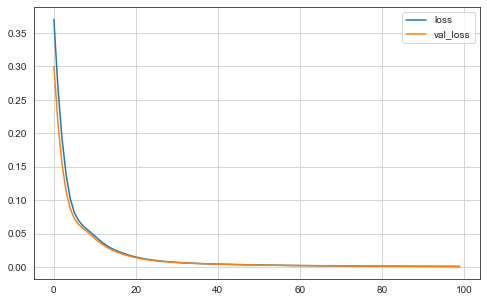

In [13]:
pd.DataFrame(history_simple_model.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [14]:
hist_simple_model = pd.DataFrame(history_simple_model.history) 
# hist_simple_model.to_pickle("../data/lstm_mlp/mlp_models/hist_simple_model.pkl")

In [15]:
## Calculate RMSE on training set
y_pred_train = simple_model.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

1.0573834150458599

In [16]:
## Calculate RMSE on validation set
y_pred_val = simple_model.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

1.0573834150458596

### Testing

In [17]:
simple_model = build_model_simple_mlp()

history_simple_model = simple_model.fit(all_train_x, all_train_y,
                    epochs=87,
                    batch_size=32,
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/87
5/5 [==============================] - 0s 1ms/step - loss: 0.3142
Epoch 2/87
5/5 [==============================] - 0s 1ms/step - loss: 0.2413
Epoch 3/87
5/5 [==============================] - 0s 1ms/step - loss: 0.1976
Epoch 4/87
5/5 [==============================] - 0s 1ms/step - loss: 0.1646
Epoch 5/87
5/5 [==============================] - 0s 997us/step - loss: 0.1398
Epoch 6/87
5/5 [==============================] - 0s 1ms/step - loss: 0.1172
Epoch 7/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0991
Epoch 8/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0856
Epoch 9/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0751
Epoch 10/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 11/87
5/5 [==============================] - 0s 2ms/step - loss: 0.0589
Epoch 12/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 13/87
5/5 [==============================] - 0s 2ms/step - loss: 

In [18]:
## Calculate RMSE on test set
y_pred_test = simple_model.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

1.200016289951474

### Test 10 times

In [19]:
simple_model = build_model_simple_mlp()
epochs = 87
batch_size = 32
train_score, test_score = test_10_times(simple_model, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/87
5/5 [==============================] - 0s 741us/step - loss: 1.5592
Epoch 2/87
5/5 [==============================] - 0s 750us/step - loss: 1.2091
Epoch 3/87
5/5 [==============================] - 0s 755us/step - loss: 0.9266
Epoch 4/87
5/5 [==============================] - 0s 749us/step - loss: 0.6960
Epoch 5/87
5/5 [==============================] - 0s 1ms/step - loss: 0.5211
Epoch 6/87
5/5 [==============================] - 0s 749us/step - loss: 0.3961
Epoch 7/87
5/5 [==============================] - 0s 748us/step - loss: 0.3087
Epoch 8/87
5/5 [==============================] - 0s 1ms/step - loss: 0.2513
Epoch 9/87
5/5 [==============================] - 0s 748us/step - loss: 0.2109
Epoch 10/87
5/5 [==============================] - 0s 748us/step - loss: 0.1834
Epoch 11/87
5/5 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 12/87
5/5 [==============================] - 0s 1ms/step - loss: 0.1393
Epoch 13/87
5/5 [==============================] - 0s 997

5/5 [==============================] - 0s 997us/step - loss: 0.0019
Epoch 18/87
5/5 [==============================] - 0s 997us/step - loss: 0.0019
Epoch 19/87
5/5 [==============================] - 0s 996us/step - loss: 0.0019
Epoch 20/87
5/5 [==============================] - 0s 757us/step - loss: 0.0019
Epoch 21/87
5/5 [==============================] - 0s 748us/step - loss: 0.0019
Epoch 22/87
5/5 [==============================] - 0s 998us/step - loss: 0.0019
Epoch 23/87
5/5 [==============================] - 0s 749us/step - loss: 0.0018
Epoch 24/87
5/5 [==============================] - 0s 749us/step - loss: 0.0018
Epoch 25/87
5/5 [==============================] - 0s 1000us/step - loss: 0.0018
Epoch 26/87
5/5 [==============================] - 0s 1000us/step - loss: 0.0018
Epoch 27/87
5/5 [==============================] - 0s 997us/step - loss: 0.0018
Epoch 28/87
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 29/87
5/5 [==============================] - 0

5/5 [==============================] - 0s 997us/step - loss: 8.7102e-04
Epoch 33/87
5/5 [==============================] - 0s 998us/step - loss: 8.6248e-04
Epoch 34/87
5/5 [==============================] - 0s 748us/step - loss: 8.5631e-04
Epoch 35/87
5/5 [==============================] - 0s 997us/step - loss: 8.5578e-04
Epoch 36/87
5/5 [==============================] - 0s 997us/step - loss: 8.5618e-04
Epoch 37/87
5/5 [==============================] - 0s 997us/step - loss: 8.4580e-04
Epoch 38/87
5/5 [==============================] - 0s 997us/step - loss: 8.3323e-04
Epoch 39/87
5/5 [==============================] - 0s 997us/step - loss: 8.2669e-04
Epoch 40/87
5/5 [==============================] - 0s 748us/step - loss: 8.2391e-04
Epoch 41/87
5/5 [==============================] - 0s 998us/step - loss: 8.1563e-04
Epoch 42/87
5/5 [==============================] - 0s 748us/step - loss: 8.1812e-04
Epoch 43/87
5/5 [==============================] - 0s 975us/step - loss: 8.0359e-04
Epoc

5/5 [==============================] - 0s 997us/step - loss: 4.3761e-04
Epoch 44/87
5/5 [==============================] - 0s 748us/step - loss: 4.3342e-04
Epoch 45/87
5/5 [==============================] - 0s 997us/step - loss: 4.2974e-04
Epoch 46/87
5/5 [==============================] - 0s 748us/step - loss: 4.2695e-04
Epoch 47/87
5/5 [==============================] - 0s 997us/step - loss: 4.2577e-04
Epoch 48/87
5/5 [==============================] - 0s 1ms/step - loss: 4.1848e-04
Epoch 49/87
5/5 [==============================] - 0s 998us/step - loss: 4.1691e-04
Epoch 50/87
5/5 [==============================] - 0s 997us/step - loss: 4.1527e-04
Epoch 51/87
5/5 [==============================] - 0s 997us/step - loss: 4.1148e-04
Epoch 52/87
5/5 [==============================] - 0s 997us/step - loss: 4.0849e-04
Epoch 53/87
5/5 [==============================] - 0s 997us/step - loss: 4.0760e-04
Epoch 54/87
5/5 [==============================] - 0s 997us/step - loss: 4.0684e-04
Epoch 

Epoch 54/87
5/5 [==============================] - 0s 997us/step - loss: 2.1043e-04
Epoch 55/87
5/5 [==============================] - 0s 998us/step - loss: 2.0838e-04
Epoch 56/87
5/5 [==============================] - 0s 748us/step - loss: 2.0541e-04
Epoch 57/87
5/5 [==============================] - 0s 997us/step - loss: 2.0478e-04
Epoch 58/87
5/5 [==============================] - 0s 740us/step - loss: 2.0327e-04
Epoch 59/87
5/5 [==============================] - 0s 989us/step - loss: 2.0200e-04
Epoch 60/87
5/5 [==============================] - 0s 997us/step - loss: 1.9881e-04
Epoch 61/87
5/5 [==============================] - 0s 755us/step - loss: 1.9883e-04
Epoch 62/87
5/5 [==============================] - 0s 748us/step - loss: 1.9857e-04
Epoch 63/87
5/5 [==============================] - 0s 740us/step - loss: 1.9404e-04
Epoch 64/87
5/5 [==============================] - 0s 739us/step - loss: 1.9394e-04
Epoch 65/87
5/5 [==============================] - 0s 997us/step - loss: 1.9

5/5 [==============================] - 0s 997us/step - loss: 9.1109e-05
Epoch 66/87
5/5 [==============================] - 0s 748us/step - loss: 8.8580e-05
Epoch 67/87
5/5 [==============================] - 0s 997us/step - loss: 8.8698e-05
Epoch 68/87
5/5 [==============================] - 0s 1ms/step - loss: 8.7203e-05
Epoch 69/87
5/5 [==============================] - 0s 997us/step - loss: 8.6540e-05
Epoch 70/87
5/5 [==============================] - 0s 998us/step - loss: 8.5622e-05
Epoch 71/87
5/5 [==============================] - 0s 997us/step - loss: 8.6618e-05
Epoch 72/87
5/5 [==============================] - 0s 748us/step - loss: 8.6052e-05
Epoch 73/87
5/5 [==============================] - 0s 1ms/step - loss: 8.5829e-05
Epoch 74/87
5/5 [==============================] - 0s 997us/step - loss: 8.3434e-05
Epoch 75/87
5/5 [==============================] - 0s 1ms/step - loss: 8.2049e-05
Epoch 76/87
5/5 [==============================] - 0s 997us/step - loss: 8.4335e-05
Epoch 77/8

5/5 [==============================] - 0s 997us/step - loss: 3.6086e-05
Epoch 77/87
5/5 [==============================] - 0s 997us/step - loss: 3.6068e-05
Epoch 78/87
5/5 [==============================] - 0s 1ms/step - loss: 3.6061e-05
Epoch 79/87
5/5 [==============================] - 0s 748us/step - loss: 3.5567e-05
Epoch 80/87
5/5 [==============================] - 0s 997us/step - loss: 3.5325e-05
Epoch 81/87
5/5 [==============================] - 0s 997us/step - loss: 3.6311e-05
Epoch 82/87
5/5 [==============================] - 0s 1ms/step - loss: 3.5051e-05
Epoch 83/87
5/5 [==============================] - 0s 747us/step - loss: 3.4236e-05
Epoch 84/87
5/5 [==============================] - 0s 748us/step - loss: 3.3939e-05
Epoch 85/87
5/5 [==============================] - 0s 997us/step - loss: 3.3920e-05
Epoch 86/87
5/5 [==============================] - 0s 756us/step - loss: 3.3245e-05
Epoch 87/87
5/5 [==============================] - 0s 997us/step - loss: 3.3241e-05
Epoch 1/

5/5 [==============================] - 0s 748us/step - loss: 1.6533e-05
Epoch 1/87
5/5 [==============================] - 0s 1ms/step - loss: 1.6494e-05
Epoch 2/87
5/5 [==============================] - 0s 758us/step - loss: 1.6179e-05
Epoch 3/87
5/5 [==============================] - 0s 997us/step - loss: 1.6157e-05
Epoch 4/87
5/5 [==============================] - 0s 997us/step - loss: 1.5800e-05
Epoch 5/87
5/5 [==============================] - 0s 998us/step - loss: 1.5598e-05
Epoch 6/87
5/5 [==============================] - 0s 997us/step - loss: 1.5634e-05
Epoch 7/87
5/5 [==============================] - 0s 997us/step - loss: 1.5573e-05
Epoch 8/87
5/5 [==============================] - 0s 997us/step - loss: 1.5231e-05
Epoch 9/87
5/5 [==============================] - 0s 996us/step - loss: 1.5315e-05
Epoch 10/87
5/5 [==============================] - 0s 997us/step - loss: 1.5207e-05
Epoch 11/87
5/5 [==============================] - 0s 997us/step - loss: 1.5151e-05
Epoch 12/87
5/5

5/5 [==============================] - 0s 1ms/step - loss: 8.1725e-06
Epoch 12/87
5/5 [==============================] - 0s 988us/step - loss: 8.3201e-06
Epoch 13/87
5/5 [==============================] - 0s 748us/step - loss: 8.2384e-06
Epoch 14/87
5/5 [==============================] - 0s 1ms/step - loss: 8.0206e-06
Epoch 15/87
5/5 [==============================] - 0s 1ms/step - loss: 8.1518e-06
Epoch 16/87
5/5 [==============================] - 0s 1ms/step - loss: 8.1859e-06
Epoch 17/87
5/5 [==============================] - 0s 748us/step - loss: 7.8152e-06
Epoch 18/87
5/5 [==============================] - 0s 1ms/step - loss: 7.7825e-06
Epoch 19/87
5/5 [==============================] - 0s 748us/step - loss: 7.9316e-06
Epoch 20/87
5/5 [==============================] - 0s 998us/step - loss: 7.7334e-06
Epoch 21/87
5/5 [==============================] - 0s 1ms/step - loss: 7.6487e-06
Epoch 22/87
5/5 [==============================] - 0s 756us/step - loss: 7.5298e-06
Epoch 23/87
5/5 

In [20]:
pd.DataFrame(train_score).describe()

,0
count,10.000000
mean,0.556535
std,0.529756
min,0.074366
25%,0.153181
50%,0.370299
75%,0.804129
max,1.677337


In [21]:
pd.DataFrame(test_score).describe()

,0
count,10.000000
mean,0.556535
std,0.529756
min,0.074366
25%,0.153181
50%,0.370299
75%,0.804128
max,1.677337


## Simple Model with Dropout

In [22]:
def build_model_simple_dropout():
    model_reg = keras.models.Sequential([
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal', input_shape=train_x.shape[1:]),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_reg.compile(loss='mse',
                 
        optimizer=keras.optimizers.Adam(lr=1e-3),
                  
                 )
    return model_reg

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
model_simple_dropout = build_model_simple_dropout()

history_simple_dropout = model_simple_dropout.fit(train_x, train_y,
                    epochs=100,                         
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )


C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 1s 43ms/step - loss: 0.4473 - val_loss: 0.3300
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 0.3639 - val_loss: 0.2726
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.3304 - val_loss: 0.2278
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2619 - val_loss: 0.1931
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2687 - val_loss: 0.1652
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2250 - val_loss: 0.1421
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2324 - val_loss: 0.1227
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1898 - val_loss: 0.1067
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.1642 - val_loss: 0.0938
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.1730 - val_loss: 0.0839
Epoch 11/100
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0271 - val_loss: 0.0067
Epoch 85/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0253 - val_loss: 0.0068
Epoch 86/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0069
Epoch 87/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0283 - val_loss: 0.0067
Epoch 88/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0066
Epoch 89/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0259 - val_loss: 0.0064
Epoch 90/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0272 - val_loss: 0.0061
Epoch 91/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0253 - val_loss: 0.0059
Epoch 92/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0266 - val_loss: 0.0059
Epoch 93/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0260 - val_loss: 0.0059
Epoch 94/100
4/4 [===============

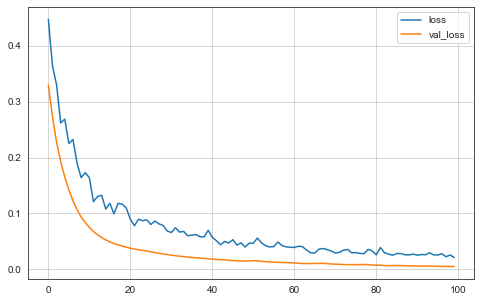

In [24]:
pd.DataFrame(history_simple_dropout.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [25]:
hist_simple_dropout = pd.DataFrame(history_simple_dropout.history) 
# hist_simple_dropout.to_pickle("../data/lstm_mlp/mlp_models/hist_simple_dropout.pkl")

In [26]:
y_pred_train = model_simple_dropout.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

2.415454564754165

In [27]:
y_pred_val = model_simple_dropout.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

2.4154545647541643

## Simple Model with weight regularization

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

def build_model_simple_weight_reg():
    model_kernel = keras.models.Sequential([
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal', input_shape=train_x.shape[1:],
                          kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_kernel.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                 
                 )
    return model_kernel

### Training

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
model_simple_weight_reg = build_model_simple_weight_reg()
history_simple_weight_reg = model_simple_weight_reg.fit(train_x, train_y,
                    epochs=200,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
4/4 [==============================] - 0s 46ms/step - loss: 0.7378 - val_loss: 0.6550
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 0.6177 - val_loss: 0.5485
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 0.5169 - val_loss: 0.4584
Epoch 4/200
4/4 [==============================] - 0s 6ms/step - loss: 0.4319 - val_loss: 0.3852
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3658 - val_loss: 0.3272
Epoch 6/200
4/4 [==============================] - 0s 6ms/step - loss: 0.3100 - val_loss: 0.2819
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2679 - val_loss: 0.2455
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2341 - val_loss: 0.2166
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 0.2069 - val_loss: 0.1929
Epoch 10/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1865 - val_loss: 0.1727
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 85/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 86/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 87/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 88/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 89/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 90/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 91/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 92/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 93/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 168/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 169/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 170/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 171/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 172/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 173/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 174/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 175/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 176/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 177/200
4/4 [=====

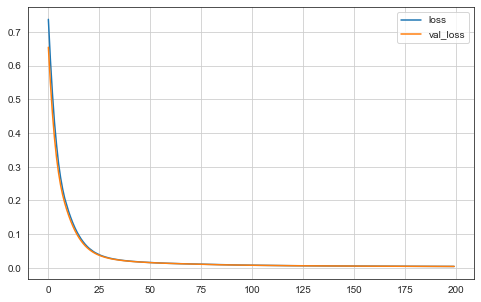

In [30]:
pd.DataFrame(history_simple_weight_reg.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [31]:
hist_model_simple_weight_reg = pd.DataFrame(history_simple_weight_reg.history) 
# hist_model_simple_weight_reg.to_pickle("../data/lstm_mlp/mlp_models/hist_model_simple_weight_reg.pkl")

In [32]:
y_pred_train = model_simple_weight_reg.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

1.4187016363944354

In [33]:
y_pred_val = model_simple_weight_reg.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

1.4187016363944356

## Model with Dropout

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

def build_model_dropout_tuned():
    model_reg = keras.models.Sequential([
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal',
                           input_shape=train_x.shape[1:],
                           kernel_constraint=keras.constraints.max_norm(max_value=1),),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal',
                          kernel_constraint=keras.constraints.max_norm(max_value=1),),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal',
                           kernel_constraint=keras.constraints.max_norm(max_value=1),),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_reg.compile(loss='mse',       
        optimizer=keras.optimizers.Adam(lr=1e-3),         
                 )
    return model_reg

### Training

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

model_dropout = build_model_dropout_tuned()
history_dropout_model = model_dropout.fit(train_x, train_y,
                    epochs=300,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback],
                                         )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
4/4 [==============================] - 1s 48ms/step - loss: 0.7122 - val_loss: 0.4339
Epoch 2/300
4/4 [==============================] - 0s 6ms/step - loss: 0.4116 - val_loss: 0.3236
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 0.3042 - val_loss: 0.2367
Epoch 4/300
4/4 [==============================] - 0s 7ms/step - loss: 0.2220 - val_loss: 0.1663
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 0.1783 - val_loss: 0.1133
Epoch 6/300
4/4 [==============================] - 0s 6ms/step - loss: 0.1124 - val_loss: 0.0779
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 0.1228 - val_loss: 0.0598
Epoch 8/300
4/4 [==============================] - 0s 7ms/step - loss: 0.1200 - val_loss: 0.0534
Epoch 9/300
4/4 [==============================] - 0s 7ms/step - loss: 0.1077 - val_loss: 0.0497
Epoch 10/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1126 - val_loss: 0.0471
Epoch 11/300
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0056
Epoch 85/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0069
Epoch 86/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0247 - val_loss: 0.0085
Epoch 87/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0088
Epoch 88/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0259 - val_loss: 0.0080
Epoch 89/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0071
Epoch 90/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0279 - val_loss: 0.0061
Epoch 91/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0237 - val_loss: 0.0054
Epoch 92/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0046
Epoch 93/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0042
Epoch 94/300
4/4 [===============

Epoch 167/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0031
Epoch 168/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0188 - val_loss: 0.0030
Epoch 169/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.0026
Epoch 170/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0186 - val_loss: 0.0024
Epoch 171/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0025
Epoch 172/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0143 - val_loss: 0.0025
Epoch 173/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0029
Epoch 174/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0027
Epoch 175/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0025
Epoch 176/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0023
Epoch 177/

4/4 [==============================] - 0s 8ms/step - loss: 0.0143 - val_loss: 0.0022
Epoch 250/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0020
Epoch 251/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0150 - val_loss: 0.0021
Epoch 252/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 253/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0020
Epoch 254/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0018
Epoch 255/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0017
Epoch 256/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 257/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0023
Epoch 258/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0031
Epoch 259/300
4/4 [=====

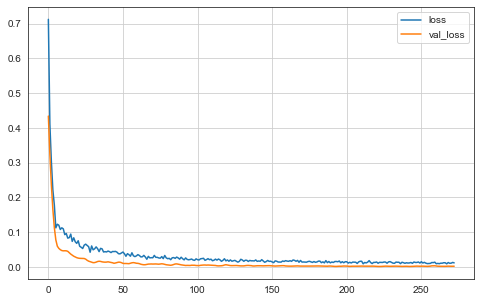

In [36]:
pd.DataFrame(history_dropout_model.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [37]:
hist_model_dropout = pd.DataFrame(history_dropout_model.history) 
# hist_model_dropout.to_pickle("../data/lstm_mlp/mlp_models/hist_model_dropout.pkl")

In [38]:
y_pred_train = model_dropout.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

1.4914632545248827

In [39]:
y_pred_val = model_dropout.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

1.4914632545248827

### Testing

In [40]:
model_dropout = build_model_dropout_tuned()

history_model_dropout = model_dropout.fit(all_train_x, all_train_y,
                    epochs=206,
                    batch_size=32,
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/206
5/5 [==============================] - 1s 1ms/step - loss: 0.4374
Epoch 2/206
5/5 [==============================] - 0s 1ms/step - loss: 0.2846
Epoch 3/206
5/5 [==============================] - 0s 998us/step - loss: 0.2035
Epoch 4/206
5/5 [==============================] - 0s 1ms/step - loss: 0.1556
Epoch 5/206
5/5 [==============================] - 0s 1ms/step - loss: 0.1277
Epoch 6/206
5/5 [==============================] - 0s 841us/step - loss: 0.1206
Epoch 7/206
5/5 [==============================] - 0s 998us/step - loss: 0.1013
Epoch 8/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0821
Epoch 9/206
5/5 [==============================] - 0s 998us/step - loss: 0.0736
Epoch 10/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 11/206
5/5 [==============================] - 0s 747us/step - loss: 0.0723
Epoch 12/206
5/5 [==============================] - 0s 997us/step - loss: 0.0626
Epoch 13/206
5/5 [==============================]

5/5 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 104/206
5/5 [==============================] - 0s 997us/step - loss: 0.0151
Epoch 105/206
5/5 [==============================] - 0s 997us/step - loss: 0.0129
Epoch 106/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 107/206
5/5 [==============================] - 0s 997us/step - loss: 0.0164
Epoch 108/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 109/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 110/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 111/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 112/206
5/5 [==============================] - 0s 997us/step - loss: 0.0143
Epoch 113/206
5/5 [==============================] - 0s 997us/step - loss: 0.0147
Epoch 114/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 115/206
5/5 [=========================

5/5 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 205/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 206/206
5/5 [==============================] - 0s 997us/step - loss: 0.0108


In [41]:
y_pred_test = model_dropout.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

1.3482893801253082

In [42]:
model_dropout = build_model_dropout_tuned()
epochs = 206
batch_size = 32
train_score, test_score = test_10_times(model_dropout, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/206
5/5 [==============================] - 1s 1ms/step - loss: 0.4349
Epoch 2/206
5/5 [==============================] - 0s 999us/step - loss: 0.2752
Epoch 3/206
5/5 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 4/206
5/5 [==============================] - 0s 997us/step - loss: 0.1242
Epoch 5/206
5/5 [==============================] - 0s 757us/step - loss: 0.0957
Epoch 6/206
5/5 [==============================] - 0s 1ms/step - loss: 0.1087
Epoch 7/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0788
Epoch 8/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0952
Epoch 9/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0673
Epoch 10/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0689
Epoch 11/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0653
Epoch 12/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 13/206
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 105/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 106/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 107/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 108/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 109/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 110/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 111/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 112/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 113/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 114/206
5/5 [==============================] - 0s 998us/step - loss: 0.0164
Epoch 115/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 116/206
5/5 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 206/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 1/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 2/206
5/5 [==============================] - 0s 998us/step - loss: 0.0108
Epoch 3/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 4/206
5/5 [==============================] - 0s 997us/step - loss: 0.0088
Epoch 5/206
5/5 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 6/206
5/5 [==============================] - 0s 999us/step - loss: 0.0111
Epoch 7/206
5/5 [==============================] - 0s 997us/step - loss: 0.0105
Epoch 8/206
5/5 [==============================] - 0s 748us/step - loss: 0.0115
Epoch 9/206
5/5 [==============================] - 0s 989us/step - loss: 0.0079
Epoch 10/206
5/5 [==============================] - 0s 997us/step - loss: 0.0108
Epoch 11/206
5/5 [==============================] - 0s 99

5/5 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 102/206
5/5 [==============================] - 0s 997us/step - loss: 0.0093
Epoch 103/206
5/5 [==============================] - 0s 998us/step - loss: 0.0077
Epoch 104/206
5/5 [==============================] - 0s 877us/step - loss: 0.0089
Epoch 105/206
5/5 [==============================] - 0s 997us/step - loss: 0.0101
Epoch 106/206
5/5 [==============================] - 0s 997us/step - loss: 0.0070
Epoch 107/206
5/5 [==============================] - 0s 748us/step - loss: 0.0100
Epoch 108/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 109/206
5/5 [==============================] - 0s 997us/step - loss: 0.0084
Epoch 110/206
5/5 [==============================] - 0s 989us/step - loss: 0.0076
Epoch 111/206
5/5 [==============================] - 0s 995us/step - loss: 0.0083
Epoch 112/206
5/5 [==============================] - 0s 997us/step - loss: 0.0073
Epoch 113/206
5/5 [===============

5/5 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 203/206
5/5 [==============================] - 0s 989us/step - loss: 0.0063
Epoch 204/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 205/206
5/5 [==============================] - 0s 997us/step - loss: 0.0053
Epoch 206/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 1/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 2/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 3/206
5/5 [==============================] - 0s 997us/step - loss: 0.0065
Epoch 4/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 5/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 6/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 7/206
5/5 [==============================] - 0s 997us/step - loss: 0.0065
Epoch 8/206
5/5 [==============================] - 0s 1ms/st

5/5 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 99/206
5/5 [==============================] - 0s 997us/step - loss: 0.0050
Epoch 100/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 101/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 102/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 103/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 104/206
5/5 [==============================] - 0s 997us/step - loss: 0.0059
Epoch 105/206
5/5 [==============================] - 0s 999us/step - loss: 0.0076
Epoch 106/206
5/5 [==============================] - 0s 997us/step - loss: 0.0050
Epoch 107/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 108/206
5/5 [==============================] - 0s 748us/step - loss: 0.0054
Epoch 109/206
5/5 [==============================] - 0s 998us/step - loss: 0.0048
Epoch 110/206
5/5 [========================

5/5 [==============================] - 0s 748us/step - loss: 0.0051
Epoch 200/206
5/5 [==============================] - 0s 748us/step - loss: 0.0053
Epoch 201/206
5/5 [==============================] - 0s 997us/step - loss: 0.0044
Epoch 202/206
5/5 [==============================] - 0s 997us/step - loss: 0.0050
Epoch 203/206
5/5 [==============================] - 0s 997us/step - loss: 0.0040
Epoch 204/206
5/5 [==============================] - 0s 997us/step - loss: 0.0041
Epoch 205/206
5/5 [==============================] - 0s 748us/step - loss: 0.0056
Epoch 206/206
5/5 [==============================] - 0s 997us/step - loss: 0.0042
Epoch 1/206
5/5 [==============================] - 0s 981us/step - loss: 0.0046
Epoch 2/206
5/5 [==============================] - 0s 998us/step - loss: 0.0042
Epoch 3/206
5/5 [==============================] - 0s 997us/step - loss: 0.0054
Epoch 4/206
5/5 [==============================] - 0s 997us/step - loss: 0.0052
Epoch 5/206
5/5 [=====================

5/5 [==============================] - 0s 996us/step - loss: 0.0048
Epoch 96/206
5/5 [==============================] - 0s 997us/step - loss: 0.0036
Epoch 97/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 98/206
5/5 [==============================] - 0s 997us/step - loss: 0.0027
Epoch 99/206
5/5 [==============================] - 0s 997us/step - loss: 0.0035
Epoch 100/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 101/206
5/5 [==============================] - 0s 998us/step - loss: 0.0042
Epoch 102/206
5/5 [==============================] - 0s 991us/step - loss: 0.0047
Epoch 103/206
5/5 [==============================] - 0s 997us/step - loss: 0.0040
Epoch 104/206
5/5 [==============================] - 0s 997us/step - loss: 0.0047
Epoch 105/206
5/5 [==============================] - 0s 997us/step - loss: 0.0042
Epoch 106/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 107/206
5/5 [=====================

5/5 [==============================] - 0s 997us/step - loss: 0.0048
Epoch 197/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 198/206
5/5 [==============================] - ETA: 0s - loss: 0.003 - 0s 1ms/step - loss: 0.0041
Epoch 199/206
5/5 [==============================] - 0s 997us/step - loss: 0.0037
Epoch 200/206
5/5 [==============================] - 0s 999us/step - loss: 0.0044
Epoch 201/206
5/5 [==============================] - 0s 997us/step - loss: 0.0035
Epoch 202/206
5/5 [==============================] - 0s 997us/step - loss: 0.0035
Epoch 203/206
5/5 [==============================] - 0s 997us/step - loss: 0.0034
Epoch 204/206
5/5 [==============================] - 0s 748us/step - loss: 0.0032
Epoch 205/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 206/206
5/5 [==============================] - 0s 997us/step - loss: 0.0040
Epoch 1/206
5/5 [==============================] - 0s 998us/step - loss: 0.0033
Epoch 2/206
5/

5/5 [==============================] - 0s 998us/step - loss: 0.0036
Epoch 92/206
5/5 [==============================] - 0s 985us/step - loss: 0.0033
Epoch 93/206
5/5 [==============================] - 0s 984us/step - loss: 0.0034
Epoch 94/206
5/5 [==============================] - 0s 987us/step - loss: 0.0037
Epoch 95/206
5/5 [==============================] - 0s 997us/step - loss: 0.0033
Epoch 96/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 97/206
5/5 [==============================] - 0s 998us/step - loss: 0.0032
Epoch 98/206
5/5 [==============================] - 0s 996us/step - loss: 0.0031
Epoch 99/206
5/5 [==============================] - 0s 988us/step - loss: 0.0033
Epoch 100/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 101/206
5/5 [==============================] - 0s 999us/step - loss: 0.0039
Epoch 102/206
5/5 [==============================] - 0s 988us/step - loss: 0.0038
Epoch 103/206
5/5 [=======================

5/5 [==============================] - 0s 925us/step - loss: 0.0030
Epoch 193/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 194/206
5/5 [==============================] - 0s 997us/step - loss: 0.0034
Epoch 195/206
5/5 [==============================] - 0s 997us/step - loss: 0.0036
Epoch 196/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 197/206
5/5 [==============================] - 0s 997us/step - loss: 0.0039
Epoch 198/206
5/5 [==============================] - 0s 997us/step - loss: 0.0039
Epoch 199/206
5/5 [==============================] - 0s 997us/step - loss: 0.0037
Epoch 200/206
5/5 [==============================] - 0s 997us/step - loss: 0.0038
Epoch 201/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 202/206
5/5 [==============================] - 0s 998us/step - loss: 0.0034
Epoch 203/206
5/5 [==============================] - 0s 991us/step - loss: 0.0031
Epoch 204/206
5/5 [=================

5/5 [==============================] - 0s 989us/step - loss: 0.0041
Epoch 89/206
5/5 [==============================] - 0s 748us/step - loss: 0.0033
Epoch 90/206
5/5 [==============================] - 0s 997us/step - loss: 0.0042
Epoch 91/206
5/5 [==============================] - 0s 997us/step - loss: 0.0041
Epoch 92/206
5/5 [==============================] - 0s 997us/step - loss: 0.0030
Epoch 93/206
5/5 [==============================] - 0s 748us/step - loss: 0.0029
Epoch 94/206
5/5 [==============================] - 0s 997us/step - loss: 0.0027
Epoch 95/206
5/5 [==============================] - 0s 997us/step - loss: 0.0029
Epoch 96/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 97/206
5/5 [==============================] - 0s 997us/step - loss: 0.0043
Epoch 98/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 99/206
5/5 [==============================] - 0s 997us/step - loss: 0.0036
Epoch 100/206
5/5 [==========================

5/5 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 189/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 190/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 191/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 192/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 193/206
5/5 [==============================] - 0s 997us/step - loss: 0.0030
Epoch 194/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 195/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 196/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 197/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 198/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 199/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 200/206
5/5 [==============================]

5/5 [==============================] - 0s 748us/step - loss: 0.0031
Epoch 85/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 86/206
5/5 [==============================] - 0s 989us/step - loss: 0.0024
Epoch 87/206
5/5 [==============================] - 0s 997us/step - loss: 0.0036
Epoch 88/206
5/5 [==============================] - 0s 748us/step - loss: 0.0030
Epoch 89/206
5/5 [==============================] - 0s 997us/step - loss: 0.0025
Epoch 90/206
5/5 [==============================] - 0s 996us/step - loss: 0.0026
Epoch 91/206
5/5 [==============================] - 0s 997us/step - loss: 0.0027
Epoch 92/206
5/5 [==============================] - 0s 997us/step - loss: 0.0034
Epoch 93/206
5/5 [==============================] - 0s 997us/step - loss: 0.0025
Epoch 94/206
5/5 [==============================] - 0s 740us/step - loss: 0.0031
Epoch 95/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 96/206
5/5 [===========================

5/5 [==============================] - 0s 998us/step - loss: 0.0032
Epoch 186/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 187/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 188/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 189/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 190/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 191/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 192/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 193/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 194/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 195/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 196/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 197/206
5/5 [==============================] -

5/5 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 83/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 84/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 85/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 86/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 87/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 88/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 89/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 90/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 91/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 92/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 93/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 94/206
5/5 [==============================] - 0s 1ms/step -

5/5 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 185/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 186/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 187/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 188/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 189/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 190/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 191/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 192/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 193/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 194/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 195/206
5/5 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 196/206
5/5 [==============================] - 0

5/5 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 82/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 83/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 84/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 85/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 86/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 87/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 88/206
5/5 [==============================] - 0s 997us/step - loss: 0.0031
Epoch 89/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 90/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 91/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 92/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 93/206
5/5 [==============================] - 0s 1ms/step

5/5 [==============================] - 0s 755us/step - loss: 0.0026
Epoch 183/206
5/5 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 184/206
5/5 [==============================] - 0s 997us/step - loss: 0.0026
Epoch 185/206
5/5 [==============================] - 0s 997us/step - loss: 0.0032
Epoch 186/206
5/5 [==============================] - 0s 998us/step - loss: 0.0034
Epoch 187/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 188/206
5/5 [==============================] - 0s 989us/step - loss: 0.0018
Epoch 189/206
5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 190/206
5/5 [==============================] - 0s 998us/step - loss: 0.0032
Epoch 191/206
5/5 [==============================] - 0s 997us/step - loss: 0.0032
Epoch 192/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 193/206
5/5 [==============================] - 0s 748us/step - loss: 0.0027
Epoch 194/206
5/5 [===============

5/5 [==============================] - 0s 997us/step - loss: 0.0031
Epoch 79/206
5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 80/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 81/206
5/5 [==============================] - 0s 997us/step - loss: 0.0029
Epoch 82/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 83/206
5/5 [==============================] - 0s 996us/step - loss: 0.0029
Epoch 84/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 85/206
5/5 [==============================] - 0s 997us/step - loss: 0.0037
Epoch 86/206
5/5 [==============================] - 0s 997us/step - loss: 0.0046
Epoch 87/206
5/5 [==============================] - 0s 997us/step - loss: 0.0023
Epoch 88/206
5/5 [==============================] - 0s 997us/step - loss: 0.0023
Epoch 89/206
5/5 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 90/206
5/5 [=============================

5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 179/206
5/5 [==============================] - 0s 997us/step - loss: 0.0031
Epoch 180/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 181/206
5/5 [==============================] - 0s 997us/step - loss: 0.0030
Epoch 182/206
5/5 [==============================] - 0s 997us/step - loss: 0.0028
Epoch 183/206
5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 184/206
5/5 [==============================] - 0s 748us/step - loss: 0.0022
Epoch 185/206
5/5 [==============================] - 0s 997us/step - loss: 0.0032
Epoch 186/206
5/5 [==============================] - 0s 999us/step - loss: 0.0035
Epoch 187/206
5/5 [==============================] - 0s 997us/step - loss: 0.0027
Epoch 188/206
5/5 [==============================] - 0s 748us/step - loss: 0.0022
Epoch 189/206
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 190/206
5/5 [===============

In [43]:
pd.DataFrame(train_score).describe()

,0
count,10.000000
mean,0.911833
std,0.177300
min,0.669063
25%,0.736346
50%,0.957055
75%,1.046108
max,1.184330


In [44]:
pd.DataFrame(test_score).describe()

,0
count,10.000000
mean,0.911833
std,0.177300
min,0.669063
25%,0.736346
50%,0.957055
75%,1.046108
max,1.184330


### MLP Dropout Hyperband

### Keras Tuner implementation of Hyperband
Hyperparameter search may take a while even with limited data, resulting architectur when used with all data is provided next

In [45]:
# ## MLP with Dropout
# def model_builder_mlp (hp):
    
#     model = keras.models.Sequential()
   
#     hp_max_norm = hp.Choice("max_norm",values = [0, 1, 2])
#     hp_units = hp.Choice("unit",values = [16, 32, 64, 128, 192 ]) 
#     hp_dropout = hp.Choice("mlp_layer_dropout",values = [ 0.2, 0.3])
#     hp_number_of_layers = hp.Int("layers",min_value=0,max_value=3,step=1)
    
#     model.add(keras.layers.Dense(
#                             units= hp_units,
#                             kernel_constraint=keras.constraints.max_norm(max_value=hp_max_norm),                    
#                             activation='relu',
#                             input_shape=train_x.shape[1:]     
#                      ))
    
#     model.add(keras.layers.Dropout(hp_dropout))
    
#     for i in range(hp_number_of_layers):
#         model.add(keras.layers.Dense(
#                         units = hp_units,
#                         kernel_constraint=keras.constraints.max_norm(max_value=hp_max_norm),
#                         activation='relu',
#                         kernel_initializer='he_normal'
#                         ))
        
#         model.add(keras.layers.Dropout(hp_dropout))
    
#     model.add(keras.layers.Dense(2, kernel_initializer='he_normal'))
        
#     mlp_learning_rate = hp.Choice('learning_rate', values = [ 1e-3, 1e-4])
#     optimizer = keras.optimizers.Adam(lr=mlp_learning_rate)
    
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model

# class MyTuner(kt.tuners.Hyperband):
#   def run_trial(self, trial, *args, **kwargs):
#     kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size",values = [32, 128, 512])
#     super(MyTuner, self).run_trial(trial, *args, **kwargs)
    
# tuner = MyTuner(model_builder_mlp,
#                 objective='val_loss',
#                 max_epochs = 100,
#                 factor = 3,
#                 seed = 42,
#                 directory = "k",
#                 project_name = 'k1')


In [46]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# tuner.search(train_x,
#              train_y,
#              epochs = 150,
#              validation_data = (valid_x, valid_y),
#              callbacks = [stop_early]
#             )

### Training

#### Either: Keras Tuner implementation of Hyperband

In [47]:
# print(tuner.get_best_hyperparameters()[0].values)

In [48]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_dropout = tuner.hypermodel.build(best_hps)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# # Retrain the model
# history_hypermodel_dropout = hypermodel_dropout.fit(train_x, train_y,
#                     epochs=171,
#                     batch_size=32,
#                     validation_data=(valid_x, valid_y),
#                     callbacks=[early_stop]
#                    )

#### Or: Rebuild best Hyperband model manually

In [49]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

def build_hypermodel_dropout():
    model_reg = keras.models.Sequential([
        keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',
                           input_shape=train_x.shape[1:],
                           kernel_constraint=keras.constraints.max_norm(max_value=1),),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',
                          kernel_constraint=keras.constraints.max_norm(max_value=1),),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_reg.compile(loss='mse',
        optimizer=keras.optimizers.Adam(lr=1e-3),     
                 )
    return model_reg

In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

hypermodel_dropout = build_hypermodel_dropout()

history_hypermodel_dropout = hypermodel_dropout.fit(train_x, train_y,
                    epochs=200,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
4/4 [==============================] - 1s 44ms/step - loss: 0.5769 - val_loss: 0.1903
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1737 - val_loss: 0.0823
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1438 - val_loss: 0.0887
Epoch 4/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1230 - val_loss: 0.0524
Epoch 5/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0821 - val_loss: 0.0280
Epoch 6/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0647 - val_loss: 0.0304
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0578 - val_loss: 0.0305
Epoch 8/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0539 - val_loss: 0.0206
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0451 - val_loss: 0.0109
Epoch 10/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0079
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0013
Epoch 85/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0014
Epoch 86/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0025
Epoch 87/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0036
Epoch 88/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0024
Epoch 89/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 90/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0031
Epoch 91/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 92/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0017
Epoch 93/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 94/200
4/4 [===============

Epoch 167/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 168/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 169/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 170/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 171/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 172/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 173/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 174/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 175/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 176/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 177/

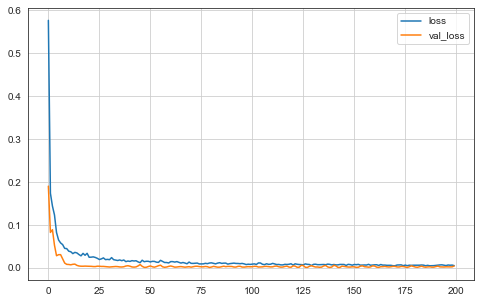

In [51]:
pd.DataFrame(history_hypermodel_dropout.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [52]:
hist_hypermodel_dropout= pd.DataFrame(history_hypermodel_dropout.history) 
# hist_hypermodel_dropout.to_pickle("../data/lstm_mlp/mlp_models/hist_hypermodel_dropout.pkl")

In [53]:
y_pred_train = hypermodel_dropout.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)
np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

2.2297363111621347

In [54]:
y_pred_val = hypermodel_dropout.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

2.229736311162135

### Testing
#### Either: rebuild Keras Tuner model

In [55]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_dropout = tuner.hypermodel.build(best_hps)

# # Retrain the model
# history_hypermodel_dropout = hypermodel_dropout.fit(all_train_x, all_train_y,
#                     epochs=92,
#                     batch_size=32,
#                     validation_data=(valid_x, valid_y),
#                     callbacks=[early_stop]
#                    )

#### Or: rebuild best model manually

In [56]:
hypermodel_dropout = build_hypermodel_dropout()

history_hypermodel_dropout = hypermodel_dropout.fit(all_train_x, all_train_y,
                    epochs=92,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/92
5/5 [==============================] - 0s 32ms/step - loss: 0.3084 - val_loss: 0.0671
Epoch 2/92
5/5 [==============================] - 0s 5ms/step - loss: 0.1140 - val_loss: 0.0694
Epoch 3/92
5/5 [==============================] - 0s 4ms/step - loss: 0.1081 - val_loss: 0.0320
Epoch 4/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0691 - val_loss: 0.0274
Epoch 5/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0574 - val_loss: 0.0280
Epoch 6/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0189
Epoch 7/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0112
Epoch 8/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0454 - val_loss: 0.0081
Epoch 9/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.0074
Epoch 10/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0418 - val_loss: 0.0072
Epoch 11/92
5/5 [=====================

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0062
Epoch 86/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0016
Epoch 87/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0032
Epoch 88/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 89/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 90/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 91/92
5/5 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 92/92
5/5 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0048


In [57]:
y_pred_test = hypermodel_dropout.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

2.3937628702930325

### Test 10 times

In [58]:
hypermodel_dropout = build_hypermodel_dropout()
epochs = 92
batch_size = 32
train_score, test_score = test_10_times(hypermodel_dropout, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/92
5/5 [==============================] - 1s 1ms/step - loss: 0.7893
Epoch 2/92
5/5 [==============================] - 0s 1ms/step - loss: 0.1518
Epoch 3/92
5/5 [==============================] - 0s 1ms/step - loss: 0.1243
Epoch 4/92
5/5 [==============================] - 0s 1ms/step - loss: 0.1338
Epoch 5/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0760
Epoch 6/92
5/5 [==============================] - 0s 998us/step - loss: 0.0606
Epoch 7/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0672
Epoch 8/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0680
Epoch 9/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 10/92
5/5 [==============================] - 0s 998us/step - loss: 0.0524
Epoch 11/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0396
Epoch 12/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0374
Epoch 13/92
5/5 [==============================] - 0s 1ms/step - loss

Epoch 14/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 15/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 16/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 17/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 18/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 19/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 20/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 21/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 22/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 23/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 24/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 25/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 26/92
5/5 [==============================] - 0s 1ms/step -

5/5 [==============================] - 0s 997us/step - loss: 0.0047
Epoch 27/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 28/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 29/92
5/5 [==============================] - 0s 997us/step - loss: 0.0043
Epoch 30/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 31/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 32/92
5/5 [==============================] - 0s 998us/step - loss: 0.0051
Epoch 33/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 34/92
5/5 [==============================] - 0s 997us/step - loss: 0.0048
Epoch 35/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 36/92
5/5 [==============================] - 0s 997us/step - loss: 0.0051
Epoch 37/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 38/92
5/5 [==============================] - 0s 1ms/step - l

5/5 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 39/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 40/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 41/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 42/92
5/5 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 43/92
5/5 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 44/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 45/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 46/92
5/5 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 47/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 48/92
5/5 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 49/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 50/92
5/5 [==============================] - 0s 1ms/step - loss: 0.003

5/5 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 51/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 52/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 53/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 54/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 55/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 56/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 57/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 58/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 59/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 60/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 61/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 62/92
5/5 [==============================] - 0s 997us/step - loss: 0.0

5/5 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 63/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 64/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 65/92
5/5 [==============================] - 0s 989us/step - loss: 0.0018
Epoch 66/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 67/92
5/5 [==============================] - 0s 997us/step - loss: 0.0017
Epoch 68/92
5/5 [==============================] - 0s 998us/step - loss: 0.0022
Epoch 69/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 70/92
5/5 [==============================] - 0s 998us/step - loss: 0.0022
Epoch 71/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 72/92
5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 73/92
5/5 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 74/92
5/5 [==============================] - 0s 1ms/step -

5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 75/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 76/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 77/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 78/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 79/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 80/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 81/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 82/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 83/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 84/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 85/92
5/5 [==============================] - 0s 997us/step - loss: 0.0014
Epoch 86/92
5/5 [==============================] - 0s 997us/step - loss: 0

Epoch 87/92
5/5 [==============================] - 0s 997us/step - loss: 0.0018
Epoch 88/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 89/92
5/5 [==============================] - 0s 994us/step - loss: 0.0019
Epoch 90/92
5/5 [==============================] - 0s 997us/step - loss: 0.0016
Epoch 91/92
5/5 [==============================] - 0s 997us/step - loss: 0.0017
Epoch 92/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 1/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 2/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 3/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 4/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 5/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 6/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 7/92
5/5 [==============================] - 0s 1ms/step 

5/5 [==============================] - 0s 997us/step - loss: 0.0013
Epoch 8/92
5/5 [==============================] - 0s 997us/step - loss: 0.0013
Epoch 9/92
5/5 [==============================] - 0s 997us/step - loss: 0.0012
Epoch 10/92
5/5 [==============================] - 0s 997us/step - loss: 0.0018
Epoch 11/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 12/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 13/92
5/5 [==============================] - 0s 998us/step - loss: 0.0016
Epoch 14/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 15/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 16/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 17/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 18/92
5/5 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 19/92
5/5 [==============================] - 0s 1ms/step - los

In [59]:
pd.DataFrame(train_score).describe()

,0
count,10.000000
mean,0.936005
std,0.571830
min,0.360964
25%,0.563951
50%,0.717547
75%,1.272365
max,1.877134


In [60]:
pd.DataFrame(test_score).describe()

,0
count,10.000000
mean,0.936005
std,0.571830
min,0.360964
25%,0.563951
50%,0.717547
75%,1.272365
max,1.877134


## Model with kernel regularization

In [61]:
def build_model_weight_reg_tuned():
    model_kernel = keras.models.Sequential([
        keras.layers.Dense(48, activation='relu',kernel_initializer='he_normal', input_shape=train_x.shape[1:],
                          kernel_regularizer=regularizers.l2(1e-4),
                          
                          ),
        keras.layers.Dense(48, activation='relu',kernel_initializer='he_normal', 
                          kernel_regularizer=regularizers.l2(1e-4),
                         
                          ),
        keras.layers.Dense(48, activation='relu',kernel_initializer='he_normal', 
                          kernel_regularizer=regularizers.l2(1e-4),
                       
                          ),
        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_kernel.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                 
                 )
    return model_kernel

### Training

In [62]:
model_weight_reg_train = build_model_weight_reg_tuned()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history_model_weight_reg_train = model_weight_reg_train.fit(train_x, train_y,
                    epochs=300,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
4/4 [==============================] - 1s 51ms/step - loss: 0.3559 - val_loss: 0.2207
Epoch 2/300
4/4 [==============================] - 0s 5ms/step - loss: 0.1879 - val_loss: 0.1463
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 0.1303 - val_loss: 0.1020
Epoch 4/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0872 - val_loss: 0.0691
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0640 - val_loss: 0.0609
Epoch 6/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0589 - val_loss: 0.0546
Epoch 7/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0465
Epoch 8/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0419
Epoch 9/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0410 - val_loss: 0.0386
Epoch 10/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0375 - val_loss: 0.0355
Epoch 11/300
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 85/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 86/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 87/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 88/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 89/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 90/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 91/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 92/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 93/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 94/300
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 168/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 169/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 170/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 171/300
4/4 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 172/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 173/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 174/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 175/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 176/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 177/300
4/4 [=====

Epoch 250/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 251/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 252/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 253/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 254/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 255/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 256/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 257/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 258/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 259/300
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 260/

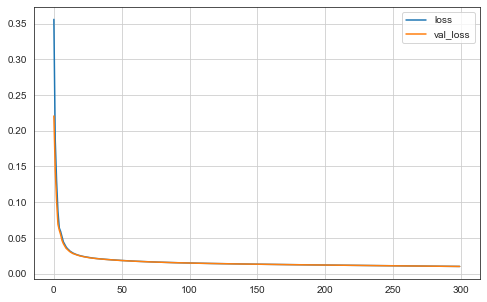

In [63]:
pd.DataFrame(history_model_weight_reg_train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [64]:
hist_model_weight_reg_train = pd.DataFrame(history_model_weight_reg_train.history) 
# hist_model_weight_reg_train.to_pickle("../data/lstm_mlp/mlp_models/hist_model_weight_reg_train.pkl")

In [65]:
model_weight_reg_train.save("../data/lstm_mlp/mlp_models/model_weight_reg_train")

INFO:tensorflow:Assets written to: ../data/lstm_mlp/mlp_models/model_weight_reg_train\assets


In [66]:
model_weight_reg_test = build_model_weight_reg_tuned()

model_weight_reg_test.fit(all_train_x, all_train_y,
                    epochs=147,
                    batch_size=32,
                   )


C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/147
5/5 [==============================] - 0s 1ms/step - loss: 0.3628
Epoch 2/147
5/5 [==============================] - 0s 997us/step - loss: 0.1144
Epoch 3/147
5/5 [==============================] - 0s 997us/step - loss: 0.0806
Epoch 4/147
5/5 [==============================] - 0s 755us/step - loss: 0.0826
Epoch 5/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0569
Epoch 6/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 7/147
5/5 [==============================] - 0s 997us/step - loss: 0.0452
Epoch 8/147
5/5 [==============================] - 0s 997us/step - loss: 0.0387
Epoch 9/147
5/5 [==============================] - 0s 998us/step - loss: 0.0344
Epoch 10/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0331
Epoch 11/147
5/5 [==============================] - 0s 997us/step - loss: 0.0308
Epoch 12/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 13/147
5/5 [=============================

5/5 [==============================] - 0s 747us/step - loss: 0.0126
Epoch 103/147
5/5 [==============================] - 0s 991us/step - loss: 0.0125
Epoch 104/147
5/5 [==============================] - 0s 985us/step - loss: 0.0125
Epoch 105/147
5/5 [==============================] - 0s 748us/step - loss: 0.0124
Epoch 106/147
5/5 [==============================] - 0s 924us/step - loss: 0.0124
Epoch 107/147
5/5 [==============================] - 0s 997us/step - loss: 0.0124
Epoch 108/147
5/5 [==============================] - 0s 988us/step - loss: 0.0123
Epoch 109/147
5/5 [==============================] - 0s 988us/step - loss: 0.0123
Epoch 110/147
5/5 [==============================] - 0s 748us/step - loss: 0.0123
Epoch 111/147
5/5 [==============================] - 0s 742us/step - loss: 0.0122
Epoch 112/147
5/5 [==============================] - 0s 988us/step - loss: 0.0122
Epoch 113/147
5/5 [==============================] - 0s 748us/step - loss: 0.0122
Epoch 114/147
5/5 [===========

In [67]:
model_weight_reg_test.save("../data/lstm_mlp/mlp_models/model_weight_reg_test")

INFO:tensorflow:Assets written to: ../data/lstm_mlp/mlp_models/model_weight_reg_test\assets


In [68]:
y_pred_test = model_weight_reg_test.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

0.10634086493075982

### Test 10 times

In [69]:
model_weight_reg = build_model_weight_reg_tuned()
epochs = 147
batch_size = 32
train_score, test_score = test_10_times(hypermodel_dropout, epochs, batch_size)

Epoch 1/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 2/147
1/5 [=====>........................] - ETA: 0s - loss: 0.0014

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 4/147
5/5 [==============================] - 0s 2ms/step - loss: 8.2566e-04
Epoch 5/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 6/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7/147
5/5 [==============================] - 0s 1ms/step - loss: 8.2119e-04
Epoch 8/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 10/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 11/147
5/5 [==============================] - 0s 998us/step - loss: 0.0011
Epoch 12/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 13/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 14/147
5/5 [==============================] - 0s 998us/s

5/5 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 105/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 106/147
5/5 [==============================] - 0s 997us/step - loss: 0.0010
Epoch 107/147
5/5 [==============================] - 0s 1ms/step - loss: 9.9695e-04
Epoch 108/147
5/5 [==============================] - 0s 1ms/step - loss: 9.8291e-04
Epoch 109/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 110/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 111/147
5/5 [==============================] - 0s 996us/step - loss: 0.0012
Epoch 112/147
5/5 [==============================] - 0s 997us/step - loss: 0.0013
Epoch 113/147
5/5 [==============================] - 0s 997us/step - loss: 0.0011
Epoch 114/147
5/5 [==============================] - 0s 997us/step - loss: 9.6936e-04
Epoch 115/147
5/5 [==============================] - 0s 962us/step - loss: 8.7657e-04
Epoch 116/147
5/5 [=======

5/5 [==============================] - 0s 997us/step - loss: 0.0011
Epoch 59/147
5/5 [==============================] - 0s 999us/step - loss: 0.0011
Epoch 60/147
5/5 [==============================] - 0s 998us/step - loss: 6.4800e-04
Epoch 61/147
5/5 [==============================] - 0s 1ms/step - loss: 9.5985e-04
Epoch 62/147
5/5 [==============================] - 0s 997us/step - loss: 9.9945e-04
Epoch 63/147
5/5 [==============================] - 0s 1ms/step - loss: 9.3168e-04
Epoch 64/147
5/5 [==============================] - 0s 988us/step - loss: 0.0011
Epoch 65/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 66/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 67/147
5/5 [==============================] - 0s 997us/step - loss: 0.0010
Epoch 68/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 69/147
5/5 [==============================] - 0s 998us/step - loss: 0.0010
Epoch 70/147
5/5 [=================

5/5 [==============================] - 0s 1ms/step - loss: 9.5512e-04
Epoch 11/147
5/5 [==============================] - 0s 997us/step - loss: 0.0010
Epoch 12/147
5/5 [==============================] - 0s 1ms/step - loss: 7.8461e-04
Epoch 13/147
5/5 [==============================] - 0s 1ms/step - loss: 8.8700e-04
Epoch 14/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 15/147
5/5 [==============================] - 0s 1ms/step - loss: 9.8692e-04
Epoch 16/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 17/147
5/5 [==============================] - 0s 979us/step - loss: 9.0484e-04
Epoch 18/147
5/5 [==============================] - 0s 1ms/step - loss: 9.9314e-04
Epoch 19/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 20/147
5/5 [==============================] - 0s 1ms/step - loss: 9.7207e-04
Epoch 21/147
5/5 [==============================] - 0s 997us/step - loss: 9.5237e-04
Epoch 22/147
5/5 [=========

5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 110/147
5/5 [==============================] - 0s 1ms/step - loss: 9.5899e-04
Epoch 111/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6844e-04
Epoch 112/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 113/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6044e-04
Epoch 114/147
5/5 [==============================] - 0s 997us/step - loss: 7.6823e-04
Epoch 115/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6536e-04
Epoch 116/147
5/5 [==============================] - 0s 997us/step - loss: 8.7236e-04
Epoch 117/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 118/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 119/147
5/5 [==============================] - 0s 997us/step - loss: 8.8748e-04
Epoch 120/147
5/5 [==============================] - 0s 999us/step - loss: 8.1142e-04
Epoch 121/147


5/5 [==============================] - 0s 1ms/step - loss: 7.1127e-04
Epoch 61/147
5/5 [==============================] - 0s 997us/step - loss: 8.4420e-04
Epoch 62/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6942e-04
Epoch 63/147
5/5 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 64/147
5/5 [==============================] - 0s 1ms/step - loss: 8.5619e-04
Epoch 65/147
5/5 [==============================] - 0s 1ms/step - loss: 6.8958e-04
Epoch 66/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4726e-04
Epoch 67/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0676e-04
Epoch 68/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 69/147
5/5 [==============================] - 0s 1ms/step - loss: 8.0646e-04
Epoch 70/147
5/5 [==============================] - 0s 997us/step - loss: 8.0811e-04
Epoch 71/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 72/147
5/5 [=======

5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 12/147
5/5 [==============================] - 0s 1ms/step - loss: 9.3025e-04
Epoch 13/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3272e-04
Epoch 14/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3857e-04
Epoch 15/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3791e-04
Epoch 16/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 17/147
5/5 [==============================] - 0s 1ms/step - loss: 8.2222e-04
Epoch 18/147
5/5 [==============================] - 0s 1ms/step - loss: 9.1100e-04
Epoch 19/147
5/5 [==============================] - 0s 1ms/step - loss: 9.5548e-04
Epoch 20/147
5/5 [==============================] - 0s 1ms/step - loss: 7.2350e-04
Epoch 21/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 22/147
5/5 [==============================] - 0s 1ms/step - loss: 7.2046e-04
Epoch 23/147
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 7.9984e-04
Epoch 110/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 111/147
5/5 [==============================] - 0s 1ms/step - loss: 8.4069e-04
Epoch 112/147
5/5 [==============================] - 0s 997us/step - loss: 7.1553e-04
Epoch 113/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3656e-04
Epoch 114/147
5/5 [==============================] - 0s 1ms/step - loss: 7.9073e-04
Epoch 115/147
5/5 [==============================] - 0s 998us/step - loss: 8.5050e-04
Epoch 116/147
5/5 [==============================] - 0s 997us/step - loss: 7.6352e-04
Epoch 117/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0641e-04
Epoch 118/147
5/5 [==============================] - 0s 1ms/step - loss: 6.9712e-04
Epoch 119/147
5/5 [==============================] - 0s 1ms/step - loss: 6.2921e-04
Epoch 120/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3669e-04
Epoc

5/5 [==============================] - 0s 1ms/step - loss: 9.1007e-04
Epoch 61/147
5/5 [==============================] - 0s 1ms/step - loss: 8.1337e-04
Epoch 62/147
5/5 [==============================] - 0s 1ms/step - loss: 6.4286e-04
Epoch 63/147
5/5 [==============================] - 0s 997us/step - loss: 6.4320e-04
Epoch 64/147
5/5 [==============================] - 0s 1ms/step - loss: 7.9451e-04
Epoch 65/147
5/5 [==============================] - 0s 1ms/step - loss: 5.6214e-04
Epoch 66/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3742e-04
Epoch 67/147
5/5 [==============================] - 0s 997us/step - loss: 6.2428e-04
Epoch 68/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3893e-04
Epoch 69/147
5/5 [==============================] - 0s 1ms/step - loss: 7.5736e-04
Epoch 70/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4416e-04
Epoch 71/147
5/5 [==============================] - 0s 1ms/step - loss: 8.5092e-04
Epoch 72/147


5/5 [==============================] - 0s 1ms/step - loss: 7.8150e-04
Epoch 12/147
5/5 [==============================] - 0s 998us/step - loss: 8.7094e-04
Epoch 13/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4950e-04
Epoch 14/147
5/5 [==============================] - 0s 1ms/step - loss: 8.9084e-04
Epoch 15/147
5/5 [==============================] - 0s 997us/step - loss: 7.3318e-04
Epoch 16/147
5/5 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 17/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1412e-04
Epoch 18/147
5/5 [==============================] - 0s 998us/step - loss: 6.6264e-04
Epoch 19/147
5/5 [==============================] - 0s 998us/step - loss: 8.3694e-04
Epoch 20/147
5/5 [==============================] - 0s 1ms/step - loss: 7.9288e-04
Epoch 21/147
5/5 [==============================] - 0s 997us/step - loss: 7.5852e-04
Epoch 22/147
5/5 [==============================] - 0s 997us/step - loss: 0.0010
Epoch 23/147


5/5 [==============================] - 0s 1ms/step - loss: 8.2021e-04
Epoch 110/147
5/5 [==============================] - 0s 1ms/step - loss: 6.2039e-04
Epoch 111/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3030e-04
Epoch 112/147
5/5 [==============================] - 0s 1ms/step - loss: 7.8205e-04
Epoch 113/147
5/5 [==============================] - 0s 1ms/step - loss: 7.2319e-04
Epoch 114/147
5/5 [==============================] - 0s 1ms/step - loss: 8.4613e-04
Epoch 115/147
5/5 [==============================] - 0s 1ms/step - loss: 9.2217e-04
Epoch 116/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1117e-04
Epoch 117/147
5/5 [==============================] - 0s 1ms/step - loss: 9.1120e-04
Epoch 118/147
5/5 [==============================] - 0s 1ms/step - loss: 5.8531e-04
Epoch 119/147
5/5 [==============================] - 0s 1ms/step - loss: 5.8576e-04
Epoch 120/147
5/5 [==============================] - 0s 997us/step - loss: 5.8564e-04
Epoc

5/5 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 61/147
5/5 [==============================] - 0s 1ms/step - loss: 9.3425e-04
Epoch 62/147
5/5 [==============================] - 0s 1ms/step - loss: 7.5348e-04
Epoch 63/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6747e-04
Epoch 64/147
5/5 [==============================] - 0s 997us/step - loss: 8.2040e-04
Epoch 65/147
5/5 [==============================] - 0s 1ms/step - loss: 6.2480e-04
Epoch 66/147
5/5 [==============================] - 0s 1ms/step - loss: 6.1806e-04
Epoch 67/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0554e-04
Epoch 68/147
5/5 [==============================] - 0s 1ms/step - loss: 9.0107e-04
Epoch 69/147
5/5 [==============================] - 0s 1ms/step - loss: 7.3044e-04
Epoch 70/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1224e-04
Epoch 71/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0035e-04
Epoch 72/147
5/5 [=

5/5 [==============================] - 0s 1ms/step - loss: 7.2059e-04
Epoch 12/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4257e-04
Epoch 13/147
5/5 [==============================] - 0s 1ms/step - loss: 7.3090e-04
Epoch 14/147
5/5 [==============================] - 0s 997us/step - loss: 8.7476e-04
Epoch 15/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0240e-04
Epoch 16/147
5/5 [==============================] - 0s 1ms/step - loss: 9.6965e-04
Epoch 17/147
5/5 [==============================] - 0s 1ms/step - loss: 5.4995e-04
Epoch 18/147
5/5 [==============================] - 0s 1ms/step - loss: 7.6354e-04
Epoch 19/147
5/5 [==============================] - 0s 1ms/step - loss: 6.1788e-04
Epoch 20/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3054e-04
Epoch 21/147
5/5 [==============================] - 0s 997us/step - loss: 8.6728e-04
Epoch 22/147
5/5 [==============================] - 0s 997us/step - loss: 8.3309e-04
Epoch 23/14

5/5 [==============================] - 0s 1ms/step - loss: 6.1882e-04
Epoch 110/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4674e-04
Epoch 111/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4352e-04
Epoch 112/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1599e-04
Epoch 113/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1914e-04
Epoch 114/147
5/5 [==============================] - 0s 1ms/step - loss: 6.8638e-04
Epoch 115/147
5/5 [==============================] - 0s 1ms/step - loss: 6.2356e-04
Epoch 116/147
5/5 [==============================] - 0s 1ms/step - loss: 6.6251e-04
Epoch 117/147
5/5 [==============================] - 0s 1ms/step - loss: 6.7795e-04
Epoch 118/147
5/5 [==============================] - 0s 1ms/step - loss: 6.7537e-04
Epoch 119/147
5/5 [==============================] - 0s 1ms/step - loss: 6.4865e-04
Epoch 120/147
5/5 [==============================] - 0s 1ms/step - loss: 6.2629e-04
Epoch 

5/5 [==============================] - 0s 1ms/step - loss: 9.2029e-04
Epoch 61/147
5/5 [==============================] - 0s 1ms/step - loss: 8.3248e-04
Epoch 62/147
5/5 [==============================] - 0s 1ms/step - loss: 8.9578e-04
Epoch 63/147
5/5 [==============================] - 0s 1ms/step - loss: 8.1477e-04
Epoch 64/147
5/5 [==============================] - 0s 1ms/step - loss: 6.8712e-04
Epoch 65/147
5/5 [==============================] - 0s 1ms/step - loss: 6.7396e-04
Epoch 66/147
5/5 [==============================] - 0s 1ms/step - loss: 7.4415e-04
Epoch 67/147
5/5 [==============================] - 0s 1ms/step - loss: 6.3973e-04
Epoch 68/147
5/5 [==============================] - 0s 1ms/step - loss: 5.6184e-04
Epoch 69/147
5/5 [==============================] - 0s 1ms/step - loss: 7.7580e-04
Epoch 70/147
5/5 [==============================] - 0s 1ms/step - loss: 7.1200e-04
Epoch 71/147
5/5 [==============================] - 0s 1ms/step - loss: 7.0677e-04
Epoch 72/147
5/5 

In [70]:
pd.DataFrame(train_score).describe()

,0
count,10.000000
mean,0.309633
std,0.080355
min,0.171825
25%,0.245744
50%,0.320421
75%,0.372896
max,0.406191


In [71]:
pd.DataFrame(test_score).describe()

,0
count,10.000000
mean,0.309633
std,0.080355
min,0.171825
25%,0.245744
50%,0.320421
75%,0.372896
max,0.406191


### MLP Dropout Hyperband

### Keras Tuner implementation of Hyperband
Hyperparameter search may take a while even with limited data, resulting architectur when used with all data is provided next

In [72]:
# def model_builder_mlp (hp):
    
#     model = keras.models.Sequential()
#     hp_kernel_reg = hp.Choice("mlp_layer_kernel_reg",values = [1e-3, 1e-4])
#     hp_units = hp.Choice("unit",values = [16, 32, 64, 128, 192 ]) 
#     hp_number_of_layers = hp.Choice("layers",values = [0,1,2,3]) 
    
#     model.add(keras.layers.Dense(
#                             units= hp_units, 
#                             kernel_regularizer=regularizers.l2(hp_kernel_reg),          
#                             activation='relu',
#                             input_shape=train_x.shape[1:]     
#                      ))

#     for i in range(hp_number_of_layers):
#         model.add(keras.layers.Dense(
#                         units = hp_units,
#                         kernel_regularizer=regularizers.l2(hp_kernel_reg),
#                         activation='relu',
#                         kernel_initializer='he_normal'
#                         ))

#     model.add(keras.layers.Dense(2, kernel_initializer='he_normal'))
        
#     mlp_learning_rate = hp.Choice('learning_rate', values = [ 1e-3, 1e-4])
#     optimizer = keras.optimizers.Adam(lr=mlp_learning_rate)
    
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model
              
              
# class MyTuner(kt.tuners.Hyperband):
#   def run_trial(self, trial, *args, **kwargs):
#     kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size",values = [32, 128, 512])
#     super(MyTuner, self).run_trial(trial, *args, **kwargs)
    
# tuner = MyTuner(model_builder_mlp,
#                 objective='val_loss',
#                 max_epochs = 100,
#                 factor = 3,
#                 seed = 42,
#                 directory = "k",
#                 project_name = 'k2')

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# tuner.search(train_x,
#              train_y,
#              epochs = 150,
#              validation_data = (valid_x, valid_y),
#              callbacks = [stop_early]
#             )

### Training

#### Either: Keras Tuner implementation of Hyperband

In [73]:
# print(tuner.get_best_hyperparameters()[0].values)

In [74]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_weight_reg = tuner.hypermodel.build(best_hps)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# # Retrain the model
# history_hypermodel_weight_reg = hypermodel_weight_reg.fit(train_x, train_y,
#                     epochs=171,
#                     batch_size=32,
#                     validation_data=(valid_x, valid_y),
#                     callbacks=[early_stop]
#                    )

#### Or: Rebuild best Hyperband model manually

In [75]:
def build_hypermodel_weight_reg():
    model_reg = keras.models.Sequential([
        keras.layers.Dense(320, activation='relu',kernel_initializer='he_normal',
                           input_shape=train_x.shape[1:],
                            kernel_regularizer=regularizers.l2(0.0001)),
        keras.layers.Dense(320, activation='relu',kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l2(0.0001)),
        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])
    model_reg.compile(loss='mse',
        optimizer=keras.optimizers.Adam(lr=1e-3),     
                 )
    return model_reg

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

hypermodel_weight_reg = build_hypermodel_weight_reg()

history_hypermodel_weight_reg = hypermodel_weight_reg.fit(train_x, train_y,
                    epochs=200,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
4/4 [==============================] - 0s 52ms/step - loss: 0.5489 - val_loss: 0.3363
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2636 - val_loss: 0.2555
Epoch 3/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2428 - val_loss: 0.1621
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1600 - val_loss: 0.1702
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1556 - val_loss: 0.1360
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1400 - val_loss: 0.1468
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1371 - val_loss: 0.1234
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1250 - val_loss: 0.1214
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1168 - val_loss: 0.1169
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1175 - val_loss: 0.1125
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 7ms/step - loss: 0.0645 - val_loss: 0.0643
Epoch 85/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0642 - val_loss: 0.0640
Epoch 86/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0639 - val_loss: 0.0638
Epoch 87/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0637 - val_loss: 0.0635
Epoch 88/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0634 - val_loss: 0.0632
Epoch 89/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0632 - val_loss: 0.0630
Epoch 90/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0629 - val_loss: 0.0627
Epoch 91/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.0625
Epoch 92/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0624 - val_loss: 0.0622
Epoch 93/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0621 - val_loss: 0.0620
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 0.0485 - val_loss: 0.0484
Epoch 168/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0484 - val_loss: 0.0483
Epoch 169/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0482 - val_loss: 0.0482
Epoch 170/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0481 - val_loss: 0.0480
Epoch 171/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0480 - val_loss: 0.0479
Epoch 172/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0479 - val_loss: 0.0478
Epoch 173/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0478 - val_loss: 0.0476
Epoch 174/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.0475
Epoch 175/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0475 - val_loss: 0.0475
Epoch 176/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0475 - val_loss: 0.0472
Epoch 177/200
4/4 [=====

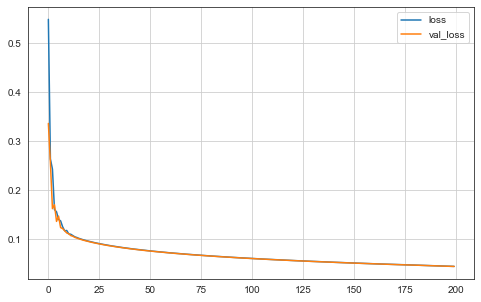

In [77]:
pd.DataFrame(history_hypermodel_weight_reg.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [78]:
hist_hypermodel_weight_reg = pd.DataFrame(history_hypermodel_weight_reg.history) 
# hist_hypermodel_weight_reg.to_pickle("../data/lstm_mlp/mlp_models/hist_hypermodel_weight_reg.pkl")

In [79]:
y_pred_train = hypermodel_weight_reg.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)
np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

0.09587492201591065

In [80]:
y_pred_val = hypermodel_weight_reg.predict(valid_x)
y_val_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_val_unsc = scaler_train_y.inverse_transform(y_pred_val)
np.sqrt(mean_squared_error(y_val_unsc, y_pred_val_unsc))                       

0.09587699284560569

### Testing
#### Either: rebuild Keras Tuner model

In [81]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_weight_reg = tuner.hypermodel.build(best_hps)

# # Retrain the model
# history_hypermodel_weight_reg = hypermodel_weight_reg.fit(all_train_x, all_train_y,
#                     epochs=109,
#                     batch_size=32,
#                     validation_data=(valid_x, valid_y),
#                     callbacks=[early_stop]
#                    )

#### Or: rebuild best model manually

In [82]:
hypermodel_weight_reg = build_hypermodel_weight_reg()

history_hypermodel_weight_reg = hypermodel_weight_reg.fit(all_train_x, all_train_y,
                    epochs=109,
                    batch_size=32,
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/109
5/5 [==============================] - 0s 35ms/step - loss: 0.2782 - val_loss: 0.2296
Epoch 2/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1890 - val_loss: 0.1722
Epoch 3/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1507 - val_loss: 0.1508
Epoch 4/109
5/5 [==============================] - 0s 6ms/step - loss: 0.1363 - val_loss: 0.1310
Epoch 5/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1273 - val_loss: 0.1270
Epoch 6/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1202 - val_loss: 0.1175
Epoch 7/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1149 - val_loss: 0.1122
Epoch 8/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1098 - val_loss: 0.1090
Epoch 9/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1070 - val_loss: 0.1048
Epoch 10/109
5/5 [==============================] - 0s 5ms/step - loss: 0.1036 - val_loss: 0.1028
Epoch 11/109
5/5 [==========

5/5 [==============================] - 0s 5ms/step - loss: 0.0533 - val_loss: 0.0531
Epoch 85/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0530 - val_loss: 0.0529
Epoch 86/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0527 - val_loss: 0.0526
Epoch 87/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0525 - val_loss: 0.0523
Epoch 88/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 89/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0519 - val_loss: 0.0518
Epoch 90/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0517 - val_loss: 0.0515
Epoch 91/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0512
Epoch 92/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0511 - val_loss: 0.0510
Epoch 93/109
5/5 [==============================] - 0s 5ms/step - loss: 0.0509 - val_loss: 0.0507
Epoch 94/109
5/5 [===============

In [83]:
y_pred_test = hypermodel_weight_reg.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

0.38461527796058476

### Test 10 times

In [84]:
hypermodel_weight_reg = build_hypermodel_weight_reg()
epochs = 109
batch_size = 32
train_score, test_score = test_10_times(hypermodel_dropout, epochs, batch_size)

Epoch 1/109
5/5 [==============================] - 0s 1ms/step - loss: 7.9228e-04
Epoch 2/109
5/5 [==============================] - 0s 1ms/step - loss: 6.5619e-04
Epoch 3/109
1/5 [=====>........................] - ETA: 0s - loss: 7.9621e-04

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


5/5 [==============================] - 0s 1ms/step - loss: 7.2229e-04
Epoch 4/109
5/5 [==============================] - 0s 1ms/step - loss: 4.9360e-04
Epoch 5/109
5/5 [==============================] - 0s 1ms/step - loss: 7.3479e-04
Epoch 6/109
5/5 [==============================] - 0s 997us/step - loss: 6.8692e-04
Epoch 7/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2636e-04
Epoch 8/109
5/5 [==============================] - 0s 1ms/step - loss: 5.5310e-04
Epoch 9/109
5/5 [==============================] - 0s 998us/step - loss: 6.9523e-04
Epoch 10/109
5/5 [==============================] - 0s 997us/step - loss: 8.3962e-04
Epoch 11/109
5/5 [==============================] - 0s 1ms/step - loss: 8.2071e-04
Epoch 12/109
5/5 [==============================] - 0s 1ms/step - loss: 7.5415e-04
Epoch 13/109
5/5 [==============================] - 0s 998us/step - loss: 8.5132e-04
Epoch 14/109
5/5 [==============================] - 0s 998us/step - loss: 5.8411e-04
Epoch 15/109


5/5 [==============================] - 0s 1ms/step - loss: 7.6741e-04
Epoch 102/109
5/5 [==============================] - 0s 997us/step - loss: 6.1955e-04
Epoch 103/109
5/5 [==============================] - 0s 1ms/step - loss: 7.5659e-04
Epoch 104/109
5/5 [==============================] - 0s 1ms/step - loss: 8.0550e-04
Epoch 105/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7440e-04
Epoch 106/109
5/5 [==============================] - 0s 1ms/step - loss: 6.4035e-04
Epoch 107/109
5/5 [==============================] - 0s 1ms/step - loss: 7.4386e-04
Epoch 108/109
5/5 [==============================] - 0s 1ms/step - loss: 6.8055e-04
Epoch 109/109
5/5 [==============================] - 0s 997us/step - loss: 7.4930e-04
Epoch 1/109
5/5 [==============================] - 0s 1ms/step - loss: 7.7298e-04
Epoch 2/109
5/5 [==============================] - 0s 1ms/step - loss: 6.4986e-04
Epoch 3/109
5/5 [==============================] - 0s 1ms/step - loss: 7.1636e-04
Epoch 4/

5/5 [==============================] - 0s 1ms/step - loss: 7.7611e-04
Epoch 91/109
5/5 [==============================] - 0s 1ms/step - loss: 8.6354e-04
Epoch 92/109
5/5 [==============================] - 0s 2ms/step - loss: 5.2566e-04
Epoch 93/109
5/5 [==============================] - 0s 1ms/step - loss: 6.1991e-04
Epoch 94/109
5/5 [==============================] - 0s 1ms/step - loss: 5.0000e-04
Epoch 95/109
5/5 [==============================] - 0s 1ms/step - loss: 6.8328e-04
Epoch 96/109
5/5 [==============================] - 0s 1ms/step - loss: 8.3626e-04
Epoch 97/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7753e-04
Epoch 98/109
5/5 [==============================] - 0s 1ms/step - loss: 6.8262e-04
Epoch 99/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2103e-04
Epoch 100/109
5/5 [==============================] - 0s 1ms/step - loss: 7.0600e-04
Epoch 101/109
5/5 [==============================] - 0s 1ms/step - loss: 6.4292e-04
Epoch 102/109
5

5/5 [==============================] - 0s 1ms/step - loss: 7.4520e-04
Epoch 80/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6833e-04
Epoch 81/109
5/5 [==============================] - 0s 1ms/step - loss: 7.2571e-04
Epoch 82/109
5/5 [==============================] - 0s 1ms/step - loss: 7.4475e-04
Epoch 83/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6248e-04
Epoch 84/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2884e-04
Epoch 85/109
5/5 [==============================] - 0s 1ms/step - loss: 6.5511e-04
Epoch 86/109
5/5 [==============================] - 0s 1ms/step - loss: 7.7509e-04
Epoch 87/109
5/5 [==============================] - 0s 1ms/step - loss: 5.7150e-04
Epoch 88/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2278e-04
Epoch 89/109
5/5 [==============================] - 0s 1ms/step - loss: 7.0338e-04
Epoch 90/109
5/5 [==============================] - 0s 1ms/step - loss: 8.1067e-04
Epoch 91/109
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 8.8130e-04
Epoch 69/109
5/5 [==============================] - 0s 1ms/step - loss: 7.1112e-04
Epoch 70/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2006e-04
Epoch 71/109
5/5 [==============================] - 0s 1ms/step - loss: 7.5263e-04
Epoch 72/109
5/5 [==============================] - 0s 999us/step - loss: 7.0936e-04
Epoch 73/109
5/5 [==============================] - 0s 997us/step - loss: 7.3820e-04
Epoch 74/109
5/5 [==============================] - 0s 1ms/step - loss: 5.6818e-04
Epoch 75/109
5/5 [==============================] - 0s 1ms/step - loss: 6.5825e-04
Epoch 76/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7060e-04
Epoch 77/109
5/5 [==============================] - 0s 1ms/step - loss: 5.8812e-04
Epoch 78/109
5/5 [==============================] - 0s 1ms/step - loss: 7.1374e-04
Epoch 79/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7530e-04
Epoch 80/109


5/5 [==============================] - 0s 997us/step - loss: 6.1004e-04
Epoch 58/109
5/5 [==============================] - 0s 1ms/step - loss: 7.4970e-04
Epoch 59/109
5/5 [==============================] - 0s 1ms/step - loss: 5.1562e-04
Epoch 60/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7751e-04
Epoch 61/109
5/5 [==============================] - 0s 1ms/step - loss: 8.6438e-04
Epoch 62/109
5/5 [==============================] - 0s 1ms/step - loss: 5.7104e-04
Epoch 63/109
5/5 [==============================] - 0s 1ms/step - loss: 6.1984e-04
Epoch 64/109
5/5 [==============================] - 0s 1ms/step - loss: 7.5931e-04
Epoch 65/109
5/5 [==============================] - 0s 1ms/step - loss: 7.3337e-04
Epoch 66/109
5/5 [==============================] - 0s 1ms/step - loss: 6.3788e-04
Epoch 67/109
5/5 [==============================] - 0s 1ms/step - loss: 5.6292e-04
Epoch 68/109
5/5 [==============================] - 0s 1ms/step - loss: 7.9922e-04
Epoch 69/109
5/

5/5 [==============================] - 0s 1ms/step - loss: 6.2085e-04
Epoch 47/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6305e-04
Epoch 48/109
5/5 [==============================] - 0s 2ms/step - loss: 5.4038e-04
Epoch 49/109
5/5 [==============================] - 0s 1ms/step - loss: 5.1627e-04
Epoch 50/109
5/5 [==============================] - 0s 1ms/step - loss: 5.9420e-04
Epoch 51/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6529e-04
Epoch 52/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2134e-04
Epoch 53/109
5/5 [==============================] - 0s 2ms/step - loss: 6.5816e-04
Epoch 54/109
5/5 [==============================] - 0s 2ms/step - loss: 6.5156e-04
Epoch 55/109
5/5 [==============================] - 0s 1ms/step - loss: 7.2487e-04
Epoch 56/109
5/5 [==============================] - 0s 1ms/step - loss: 7.0219e-04
Epoch 57/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7335e-04
Epoch 58/109
5/5 

5/5 [==============================] - 0s 1ms/step - loss: 7.3961e-04
Epoch 36/109
5/5 [==============================] - 0s 1ms/step - loss: 6.5219e-04
Epoch 37/109
5/5 [==============================] - 0s 997us/step - loss: 7.1753e-04
Epoch 38/109
5/5 [==============================] - 0s 1ms/step - loss: 7.0101e-04
Epoch 39/109
5/5 [==============================] - 0s 1ms/step - loss: 6.9521e-04
Epoch 40/109
5/5 [==============================] - 0s 1ms/step - loss: 6.8324e-04
Epoch 41/109
5/5 [==============================] - 0s 1ms/step - loss: 7.1074e-04
Epoch 42/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2845e-04
Epoch 43/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2670e-04
Epoch 44/109
5/5 [==============================] - 0s 1ms/step - loss: 7.2205e-04
Epoch 45/109
5/5 [==============================] - 0s 1ms/step - loss: 7.0286e-04
Epoch 46/109
5/5 [==============================] - 0s 997us/step - loss: 5.8490e-04
Epoch 47/109


5/5 [==============================] - 0s 2ms/step - loss: 8.7063e-04
Epoch 25/109
5/5 [==============================] - 0s 1ms/step - loss: 6.2548e-04
Epoch 26/109
5/5 [==============================] - 0s 1ms/step - loss: 5.7692e-04
Epoch 27/109
5/5 [==============================] - 0s 1ms/step - loss: 6.9692e-04
Epoch 28/109
5/5 [==============================] - 0s 2ms/step - loss: 6.9794e-04
Epoch 29/109
5/5 [==============================] - 0s 2ms/step - loss: 5.5016e-04
Epoch 30/109
5/5 [==============================] - 0s 1ms/step - loss: 5.1085e-04
Epoch 31/109
5/5 [==============================] - 0s 1ms/step - loss: 7.6021e-04
Epoch 32/109
5/5 [==============================] - 0s 2ms/step - loss: 6.5883e-04
Epoch 33/109
5/5 [==============================] - 0s 2ms/step - loss: 7.2307e-04
Epoch 34/109
5/5 [==============================] - 0s 2ms/step - loss: 6.8611e-04
Epoch 35/109
5/5 [==============================] - 0s 2ms/step - loss: 8.2032e-04
Epoch 36/109
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 5.9974e-04
Epoch 14/109
5/5 [==============================] - 0s 1ms/step - loss: 7.6922e-04
Epoch 15/109
5/5 [==============================] - 0s 2ms/step - loss: 6.4942e-04
Epoch 16/109
5/5 [==============================] - 0s 1ms/step - loss: 8.7766e-04
Epoch 17/109
5/5 [==============================] - 0s 2ms/step - loss: 5.0434e-04
Epoch 18/109
5/5 [==============================] - 0s 2ms/step - loss: 6.9461e-04
Epoch 19/109
5/5 [==============================] - 0s 2ms/step - loss: 5.7053e-04
Epoch 20/109
5/5 [==============================] - 0s 2ms/step - loss: 7.3622e-04
Epoch 21/109
5/5 [==============================] - 0s 1ms/step - loss: 7.6510e-04
Epoch 22/109
5/5 [==============================] - 0s 2ms/step - loss: 6.9365e-04
Epoch 23/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6057e-04
Epoch 24/109
5/5 [==============================] - 0s 2ms/step - loss: 5.7961e-04
Epoch 25/109
5/5 

5/5 [==============================] - 0s 2ms/step - loss: 5.0751e-04
Epoch 3/109
5/5 [==============================] - 0s 2ms/step - loss: 6.9566e-04
Epoch 4/109
5/5 [==============================] - 0s 2ms/step - loss: 6.0185e-04
Epoch 5/109
5/5 [==============================] - 0s 2ms/step - loss: 7.7998e-04
Epoch 6/109
5/5 [==============================] - 0s 2ms/step - loss: 6.8440e-04
Epoch 7/109
5/5 [==============================] - 0s 2ms/step - loss: 5.6241e-04
Epoch 8/109
5/5 [==============================] - 0s 1ms/step - loss: 5.9312e-04
Epoch 9/109
5/5 [==============================] - 0s 2ms/step - loss: 6.0381e-04
Epoch 10/109
5/5 [==============================] - 0s 1ms/step - loss: 6.7639e-04
Epoch 11/109
5/5 [==============================] - 0s 2ms/step - loss: 5.6413e-04
Epoch 12/109
5/5 [==============================] - 0s 1ms/step - loss: 5.9288e-04
Epoch 13/109
5/5 [==============================] - 0s 1ms/step - loss: 7.8623e-04
Epoch 14/109
5/5 [======

5/5 [==============================] - 0s 1ms/step - loss: 4.5126e-04
Epoch 101/109
5/5 [==============================] - 0s 1ms/step - loss: 6.0000e-04
Epoch 102/109
5/5 [==============================] - 0s 1ms/step - loss: 5.3423e-04
Epoch 103/109
5/5 [==============================] - 0s 1ms/step - loss: 6.6089e-04
Epoch 104/109
5/5 [==============================] - 0s 1ms/step - loss: 5.2012e-04
Epoch 105/109
5/5 [==============================] - 0s 1ms/step - loss: 8.1562e-04
Epoch 106/109
5/5 [==============================] - 0s 1ms/step - loss: 4.8407e-04
Epoch 107/109
5/5 [==============================] - 0s 1ms/step - loss: 5.0672e-04
Epoch 108/109
5/5 [==============================] - 0s 2ms/step - loss: 7.7561e-04
Epoch 109/109
5/5 [==============================] - 0s 2ms/step - loss: 7.0457e-04


In [85]:
pd.DataFrame(train_score).describe()

,0
count,10.000000
mean,0.328707
std,0.097072
min,0.222530
25%,0.263377
50%,0.293989
75%,0.386389
max,0.543851


In [86]:
pd.DataFrame(test_score).describe()

,0
count,10.000000
mean,0.328707
std,0.097072
min,0.222530
25%,0.263377
50%,0.293989
75%,0.386389
max,0.543851


## Plot Simple Models

#### If not all models were run: Read saved files

In [87]:
# hist_simple_model = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_simple_model.pkl")
# hist_simple_dropout = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_simple_dropout.pkl")
# hist_model_simple_weight_reg = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_model_simple_weight_reg.pkl")

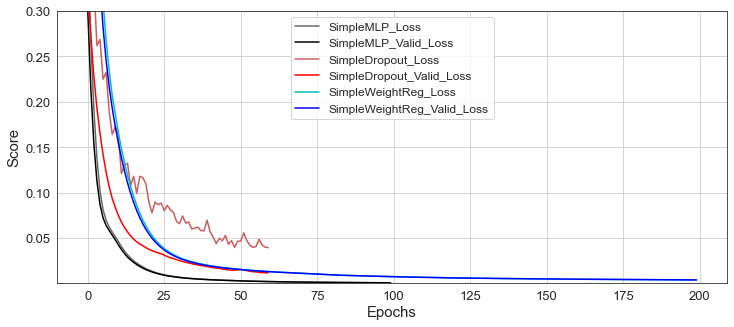

In [88]:
fig_simple_mlps, ax = plt.subplots(figsize=(12, 5))
ax.plot(hist_simple_model['loss'], label='SimpleMLP_Loss', color='dimgrey' )
ax.plot(hist_simple_model['val_loss'], label='SimpleMLP_Valid_Loss', color='black' )
ax.plot(hist_simple_dropout['loss'][:60], label='SimpleDropout_Loss', color='indianred')
ax.plot(hist_simple_dropout['val_loss'][:60], label='SimpleDropout_Valid_Loss', color='red')
ax.plot(hist_model_simple_weight_reg['loss'], label='SimpleWeightReg_Loss', color='c')
ax.plot(hist_model_simple_weight_reg['val_loss'], label='SimpleWeightReg_Valid_Loss', color='blue')
ax.set_ylim(0.001, 0.3)
ax.set(xlabel=' Epochs', ylabel='Score')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax.legend(loc='upper center',prop={'size': 12} )
ax.grid()

### Plotting tuned models

#### If not all models were run: Read saved files

In [89]:
# hist_model_dropout = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_model_dropout.pkl")
# hist_hypermodel_dropout = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_hypermodel_dropout.pkl")
# hist_model_weight_reg_train = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_model_weight_reg_train.pkl")
# hist_hypermodel_mlp_seq_weight = pd.read_pickle("../data/lstm_mlp/mlp_models/hist_hypermodel_weight_reg.pkl")

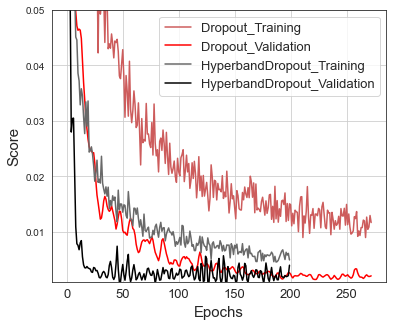

In [90]:
fig_final_mlps, ax = plt.subplots(figsize=(6, 5))
ax.plot(hist_model_dropout['loss'][:300], label='Dropout_Training', color='indianred' )
ax.plot(hist_model_dropout['val_loss'][:300], label='Dropout_Validation', color='red' )
ax.plot(hist_hypermodel_dropout['loss'][:300], label='HyperbandDropout_Training', color='dimgrey')
ax.plot(hist_hypermodel_dropout['val_loss'][:300], label='HyperbandDropout_Validation', color='black')
ax.set_ylim(0.001, 0.05)
ax.set(xlabel=' Epochs', ylabel='Score')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
plt.xticks(fontsize=13)
ax.legend(loc='upper right',prop={'size': 13} )
ax.grid()

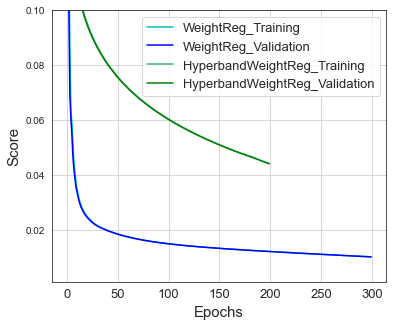

In [91]:
fig_final_mlps, ax = plt.subplots(figsize=(6, 5))
ax.plot(hist_model_weight_reg_train['loss'][:300], label='WeightReg_Training', color='c' )
ax.plot(hist_model_weight_reg_train['val_loss'][:300], label='WeightReg_Validation', color='blue' )
ax.plot(hist_hypermodel_weight_reg['loss'][:300], label='HyperbandWeightReg_Training', color='mediumseagreen')
ax.plot(hist_hypermodel_weight_reg['val_loss'][:300], label='HyperbandWeightReg_Validation', color='green')
ax.set_ylim(0.001, 0.1)
ax.set(xlabel=' Epochs', ylabel='Score')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
plt.xticks(fontsize=13)
ax.legend(loc='upper right',prop={'size': 13} )
ax.grid()

### Graphical Evaluation

In [92]:
# model_weight_reg_train = keras.models.load_model("../data/lstm_mlp/mlp_models/model_weight_reg_train")

# model_weight_reg_test = keras.models.load_model("../data/lstm_mlp/mlp_models/model_weight_reg_test")

#### use modell from training for validation loss

In [93]:
y_pred_valid = model_weight_reg_train.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)
np.sqrt(mean_squared_error(y_valid_unsc, y_pred_valid_unsc))                       

0.046107273246119

#### use model from testing for all_train and test loss

In [94]:
y_pred_train = model_weight_reg_test.predict(all_train_x)
y_train_unsc = scaler_y.inverse_transform(all_train_y)
y_pred_train_unsc = scaler_y.inverse_transform(y_pred_train)
np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

0.10634086493075981

In [95]:
y_pred_test_final = model_weight_reg_test.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc_final = scaler_y.inverse_transform(y_pred_test_final)
np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc_final))   

0.10634086493075982

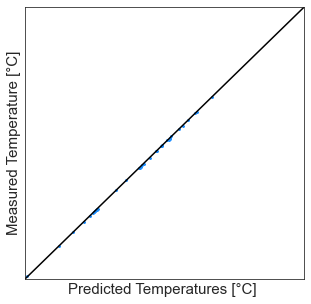

In [96]:
fig, ax1 = plt.subplots(1, figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_train_unsc, y_train_unsc, c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C] ', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

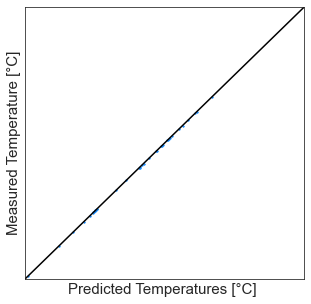

In [97]:
fig, ax1 = plt.subplots(1, figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_valid_unsc, y_valid_unsc, c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C] ', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

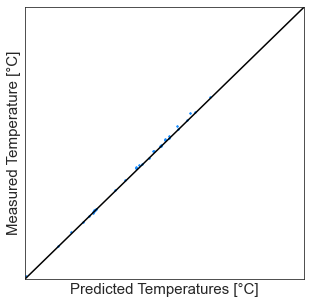

In [98]:
fig, ax1 = plt.subplots(1,  figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_test_unsc, y_test_unsc,  c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C]', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

## looking at single sequences

In [99]:
## Get predicted and real value for each sequence seperately
seq_ids = test_data.groupby('seq_id')    #group by each sequence+strand_r
seq_id_test_data = list(seq_ids.groups.keys())

df_temp_predicted = pd.DataFrame(y_pred_test_unsc_final, columns=['TempMittelLsInC_predicted','TempMittelFsInC_predicted'])
df_pred = pd.concat([df_temp_predicted, test_data['seq_id']], axis=1)

prediction = {}
real_values = {}
rmse = {}
for seq in seq_id_test_data:
    prediction[seq] = df_pred[['TempMittelLsInC_predicted', 'TempMittelFsInC_predicted']][df_pred['seq_id']==seq].to_numpy()
    real_values[seq] = test_data[['TempMittelLsInC', 'TempMittelFsInC']][test_data['seq_id']
                                                                                   ==seq].to_numpy()
    rmse[seq] = np.sqrt(mean_squared_error( prediction[seq],  real_values[seq]))  

error = []
for seq in seq_id_test_data:
    error.append((rmse[seq], seq))

In [100]:
sorted(error)

[(0.10314177800790593, '471719_str_1'),
 (0.10314177800790593, '471724_str_1'),
 (0.10314177800790593, '471728_str_1'),
 (0.10944648344196126, '471719_str_2'),
 (0.10944648344196126, '471724_str_2'),
 (0.10944648344196126, '471728_str_2')]

[[]]

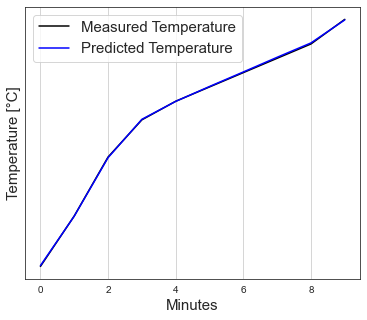

In [101]:
seq_number = '471719_str_1'
fig1, (ax1) = plt.subplots(1, figsize=(6, 5),  sharex=True, sharey=True)

ax1.plot(real_values[seq_number][:,:1], color='black', label='Measured Temperature')
ax1.plot(prediction[seq_number][:,:1], color='blue', label='Predicted Temperature')
ax1.legend(loc='best')
ax1.grid()
ax1.set_xlabel('Minutes', fontsize=15)
ax1.set_ylabel('Temperature [°C]',fontsize=15)
#ax1.set_ylim(600, 780)
ax1.yaxis.grid(False)
ax1.xaxis.grid(True)
ax1.yaxis.grid(False)
ax1.legend(prop={'size': 15})
ax1.set(yticks=[])

[[]]

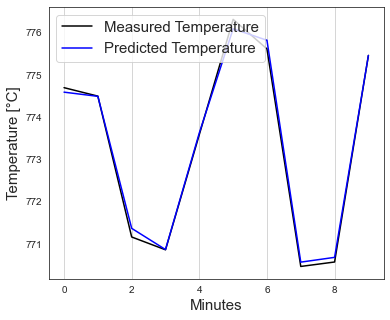

In [102]:
seq_number = '471724_str_2'
fig2, (ax2) = plt.subplots(1, figsize=(6, 5),  sharex=True, sharey=True)

ax2.plot(real_values[seq_number][:,1:2], color='black', label='Measured Temperature')
ax2.plot(prediction[seq_number][:,1:2], color='blue', label='Predicted Temperature')
ax2.legend(loc='best')
ax2.grid()
ax2.set_xlabel('Minutes', fontsize=15)
ax2.set_ylabel('Temperature [°C]',fontsize=15)
ax2.yaxis.grid(False)
ax2.xaxis.grid(True)
ax2.legend(prop={'size': 15})
ax1.set(yticks=[])